In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
import numpy as np
from sklearn import metrics
import optuna
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import f1_score
from scipy.sparse import hstack
from sklearn.utils import resample
import optuna
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from huggingface_hub import hf_hub_download
from safetensors.numpy import load_file
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [190]:
#carregar dataset
df = pd.read_csv('factnews_dataset.csv')
df.isnull().sum()

file          0
id_sente      0
id_article    0
domain        0
year          0
sentences     0
classe        0
dtype: int64

# Pré-processamento

divisão dos dados

In [191]:
'''
#criar grupo treino, validação e teste
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['classe'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['classe'])

#guardar conjuntos em memória
train_df.to_csv("train.csv", index=False) 
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)
'''

'\n#criar grupo treino, validação e teste\ntrain_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[\'classe\'])\ntrain_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[\'classe\'])\n\n#guardar conjuntos em memória\ntrain_df.to_csv("train.csv", index=False) \nval_df.to_csv("val.csv", index=False)\ntest_df.to_csv("test.csv", index=False)\n'

In [192]:
train= pd.read_csv('train.csv')
val= pd.read_csv('val.csv')
test= pd.read_csv('test.csv')

train_oversampling= pd.read_csv('train_oversampling.csv')
val_oversampling= pd.read_csv('val_oversampling.csv')
test_oversampling= pd.read_csv('test_oversampling.csv')

y_train= train['classe']
y_train_oversampling= train_oversampling['classe']

y_val=val['classe']
y_val_oversampling = val_oversampling['classe']

y_test= test['classe']
y_test_oversampling = test_oversampling['classe']

Pré-processamento da primeira meta 

In [193]:
df = pd.read_csv('factnews_dataset.csv')
def pre_processamento_meta1(df):
    stop_words = set(stopwords.words('portuguese'))
    #criar coluna tokens
    df['tokens'] = df['sentences'].apply(lambda x: nltk.word_tokenize(str(x).lower()))
    # Tokenizar sem stopwords
    df['tokens'] = df['tokens'].apply(lambda toks: [t for t in toks if t not in stop_words])
    return df

train_meta1 = pre_processamento_meta1(train)
val_meta1 = pre_processamento_meta1(val)
test_meta1= pre_processamento_meta1(test)

y_train_meta1=train_meta1['classe']
y_val_meta1=val_meta1['classe']
y_test_meta1=test_meta1['classe']

balanceamento dos dados

In [194]:
train= pd.read_csv('train.csv')
val= pd.read_csv('val.csv')
test= pd.read_csv('test.csv')

train_oversampling= pd.read_csv('train_oversampling.csv')
val_oversampling= pd.read_csv('val_oversampling.csv')
test_oversampling= pd.read_csv('test_oversampling.csv')

y_train= train['classe']
y_train_oversampling= train_oversampling['classe']

y_val=val['classe']
y_val_oversampling = val_oversampling['classe']

y_test= test['classe']
y_test_oversampling = test_oversampling['classe']

In [195]:
# Contagem das classes em cada conjunto
print ("conjunto de treino: ",y_train.value_counts().sort_index())
print("\nconjunto de validação: ",y_val.value_counts().sort_index())
print("\nconjunto de teste: ", y_test.value_counts().sort_index())
print("\nconjunto de treino + exemplos: ", y_train_oversampling.value_counts().sort_index())
print("\nconjunto de val + exemplos: ", y_val_oversampling.value_counts().sort_index())
print("\nconjunto de teste + exemplos: ", y_test_oversampling.value_counts().sort_index())

conjunto de treino:  classe
-1     779
 0    2375
 1     312
Name: count, dtype: int64

conjunto de validação:  classe
-1    195
 0    594
 1     78
Name: count, dtype: int64

conjunto de teste:  classe
-1     417
 0    1273
 1     168
Name: count, dtype: int64

conjunto de treino + exemplos:  classe
-1    2375
 0    2375
 1    2375
Name: count, dtype: int64

conjunto de val + exemplos:  classe
-1    594
 0    594
 1    594
Name: count, dtype: int64

conjunto de teste + exemplos:  classe
-1    1273
 0    1273
 1    1273
Name: count, dtype: int64


In [196]:
def balancear_classes(conjunto):
  # Separar cada classe
  class_min = conjunto[conjunto['classe'] == -1]
  class_med = conjunto[conjunto['classe'] == 1]
  class_max = conjunto[conjunto['classe'] == 0]

  # Número da classe maior
  n_samples = len(class_max)

  # Replicar as classes menores até o tamanho da maior
  class_min_upsampled = resample(class_min, 
                              replace=True, 
                              n_samples=n_samples, 
                              random_state=42)

  class_med_upsampled = resample(class_med, 
                              replace=True, 
                              n_samples=n_samples, 
                            random_state=42)

  conjunto_oversampled = pd.concat([class_min_upsampled, class_med_upsampled, class_max])

  # baralhar o conjunto 
  conjunto_oversampled = conjunto_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

  print(conjunto_oversampled['classe'].value_counts())

  return conjunto_oversampled

#train_oversampling.to_csv('train_oversampling.csv', index=False)
#val_oversampling = balancear_classes(val)
#test_oversampling= balancear_classes(test)

#val_oversampling.to_csv('val_oversampling.csv', index=False)
#test_oversampling.to_csv('test_oversampling.csv', index=False)


tokeinização

In [197]:
stop_words = set(stopwords.words('portuguese'))
def tokeinizar(train, val, test):

    #criar coluna tokens
    train['tokens'] = train['sentences'].apply(lambda x: nltk.word_tokenize(str(x)))
    val['tokens']   = val['sentences'].apply(lambda x: nltk.word_tokenize(str(x)))
    test['tokens'] = test['sentences'].apply(lambda x: nltk.word_tokenize(str(x)))
    train_oversampling['tokens'] = train_oversampling['sentences'].apply(lambda x: nltk.word_tokenize(str(x)))

    #remover stopwords
    train['tokens'] = train['tokens'].apply(lambda toks: [t for t in toks if t.lower() not in stop_words])
    val['tokens']   = val['tokens'].apply(lambda toks: [t for t in toks if t.lower() not in stop_words])
    test['tokens']  = test['tokens'].apply(lambda toks: [t for t in toks if t.lower() not in stop_words])
    train_oversampling['tokens'] = train_oversampling['tokens'].apply(lambda toks: [t for t in toks if t.lower() not in stop_words])

    #matizar
    #nltk . download ('rslp')
    stemmer = nltk . stem . RSLPStemmer ()
    train['stems'] = train['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
    val['stems']   = val['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
    test['stems'] = test['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
    train_oversampling['stems'] = train_oversampling['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

    nltk . download ('rslp')
    stemmer = nltk . stem . RSLPStemmer ()
    print(train['stems'].head())

    return train, val, test

train, val, test = tokeinizar(train, val, test)
train_oversampling, val_oversampling, test_oversampling = tokeinizar(train_oversampling, val_oversampling, test_oversampling)

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\furdu\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


0    [neym, ,, part, 20, novembr, vai, lider, seleç...
1    [forç, internac, transform, quest, taiwan, ass...
2    [alianç, mai, quant, parlament, eleit, nome, p...
3    [ger, mort, '', ,, declar, cabr, ,, 16ª, entre...
4    [bisp, barr, (, ba, ), ,, dom, luiz, flávi, ca...
Name: stems, dtype: object
0    [qued, ocorr, aliment, pux, cord, sent, contr,...
1    [repercuss, nega, cas, fez, bolsonar, ,, candi...
2    [brasil, lav, alm, após, decepcion, empat, col...
3    [final, encontr, ,, sen, tucan, diss, esp, gov...
4    [fiz, compromiss, líd, bas, hoj, líd, opos, ,,...
Name: stems, dtype: object


[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\furdu\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [198]:
y_train= train['classe']
y_train_oversampling= train_oversampling['classe']

y_val=val['classe']
y_val_oversampling = val_oversampling['classe']

y_test= test['classe']
y_test_oversampling = test_oversampling['classe']

In [199]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)


# Construção dos modelos de representação

## TF-IDF - fred

In [200]:
def objective_tfidf(trial):
    # Parâmetros a otimizar
    max_features = trial.suggest_int("max_features", 500, 5000)
    ngram_min = trial.suggest_int("ngram_min", 1, 2)
    ngram_max = trial.suggest_int("ngram_max", ngram_min, 3) 

    tfidf_vect = TfidfVectorizer(
        ngram_range=(ngram_min, ngram_max),
        max_features=max_features,
        strip_accents='unicode',
        token_pattern=r"(?u)\b\w+\b|[^\w\s]"
    )

    text_train = train['stems'].apply(lambda tokens: ' '.join(tokens))
    text_val = val['stems'].apply(lambda tokens: ' '.join(tokens))

    X_train = tfidf_vect.fit_transform(text_train)
    X_val = tfidf_vect.transform(text_val)

    y_train = train['classe']
    y_val = val['classe']

    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    score = f1_score(y_val, preds, average='macro')
    return score

def tfidf_optuna(train, val, test):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_tfidf, n_trials=30)

    best_params = study.best_params
    print("Melhores parâmetros:", best_params)

    tfidf_vect = TfidfVectorizer(
        ngram_range=(best_params['ngram_min'], best_params['ngram_max']),
        max_features=best_params['max_features'],
        strip_accents='unicode',
        token_pattern=r"(?u)\b\w+\b|[^\w\s]"
    )

    text_train = train['stems'].apply(lambda tokens: ' '.join(tokens))
    text_val = val['stems'].apply(lambda tokens: ' '.join(tokens))
    text_test = test['stems'].apply(lambda tokens: ' '.join(tokens))

    X_train = tfidf_vect.fit_transform(text_train)
    X_val = tfidf_vect.transform(text_val)
    X_test = tfidf_vect.transform(text_test)

    return X_train, X_val, X_test


In [201]:
X_train_tfidf_vec, X_val_tfidf_vec, X_test_tfidf_vec = tfidf_optuna(train,val, test)
X_train_oversampling_tfidf_vec, X_val_oversampling_tfidf_vec, X_test_oversampling_tfidf_vec = tfidf_optuna(train_oversampling, val_oversampling, test_oversampling)

Melhores parâmetros: {'max_features': 562, 'ngram_min': 1, 'ngram_max': 1}
Melhores parâmetros: {'max_features': 1368, 'ngram_min': 1, 'ngram_max': 1}


## CountVectorizer -didi

In [202]:
def objective_count_vec(trial, train, val):
    # Parâmetros a otimizar
    max_features = trial.suggest_int("max_features", 500, 5000)
    ngram_min = trial.suggest_int("ngram_min", 1, 2)
    ngram_max = trial.suggest_int("ngram_max", ngram_min, 3)  # garante ngram_max >= ngram_min

    # CountVectorizer com parâmetros sugeridos
    c_vect = CountVectorizer(
        token_pattern=r"(?u)\b\w+\b|[^\w\s]",
        ngram_range=(ngram_min, ngram_max),
        strip_accents='unicode',
        max_features=max_features
    )

    # Transformar textos
    text_train = train['stems'].apply(lambda tokens: ' '.join(tokens))
    text_val   = val['stems'].apply(lambda tokens: ' '.join(tokens))

    X_train = c_vect.fit_transform(text_train)
    X_val   = c_vect.transform(text_val)

    y_train = train['classe'] 
    y_val   = val['classe']

    # Treinar Logistic Regression
    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    # Métrica: F1 macro
    score = f1_score(y_val, preds, average='macro')
    return score 

def count_vec(train, val, test):

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_count_vec(trial, train,val),
                   n_trials=30, n_jobs=-1, show_progress_bar=False)
    
    best_params=study.best_params
    print("Melhores parâmetros:", study.best_params)
    print("Melhor F1:", study.best_value)
    
    c_vect = CountVectorizer(
        token_pattern=r"(?u)\b\w+\b|[^\w\s]",
        ngram_range=(best_params['ngram_min'], best_params['ngram_max']),
        strip_accents='unicode',
        max_features=best_params['max_features']
    )

    # Transformar textos
    text_train = train['stems'].apply(lambda tokens: ' '.join(tokens))
    text_val = val['stems'].apply(lambda tokens: ' '.join(tokens))
    text_test = test['stems'].apply(lambda tokens: ' '.join(tokens))

    # Fit no treino, transform nos outros conjuntos
    X_train = c_vect.fit_transform(text_train)
    X_val = c_vect.transform(text_val)
    X_test = c_vect.transform(text_test)

    return X_train, X_val, X_test

In [203]:
X_train_count_vec, X_val_count_vec, X_test_count_vec = count_vec(train, val, test)
X_train_oversampling_count_vec, X_val_oversampling_count_vec, X_test_oversampling_count_vec= count_vec(train_oversampling, val_oversampling, test_oversampling)

Melhores parâmetros: {'max_features': 3256, 'ngram_min': 1, 'ngram_max': 3}
Melhor F1: 0.6823813956228313
Melhores parâmetros: {'max_features': 4627, 'ngram_min': 1, 'ngram_max': 1}
Melhor F1: 0.6835634884208721


## Glove -fred

In [204]:
glove = KeyedVectors.load_word2vec_format('glove_s100.txt')

def vetor_frase_glove(tokens):
    vecs = [glove[w] for w in tokens if w in glove]
    return np.mean(vecs, axis=0) if vecs else np.zeros(glove.vector_size)

def prep_dados(dados, coluna):
    return np.vstack([vetor_frase_glove(tokens) for tokens in dados[coluna]])

In [205]:
X_train_glove = prep_dados(train, "stems")
X_val_glove = prep_dados(val, "stems")
X_test_glove = prep_dados(test, "stems")

X_train_glove_oversampling = prep_dados(train_oversampling, "stems")
X_val_glove_oversampling = prep_dados(val_oversampling, "stems")
X_test_glove_oversampling = prep_dados(test_oversampling, "stems")

## WORD2VEC -anaana

fontes : 
-   https://sites.google.com/view/nilc-usp/resources-and-tools?authuser=0
-   https://huggingface.co/nilc-nlp/word2vec-skip-gram-300d

In [206]:
def carregar_word2vec():
    path = hf_hub_download(repo_id="nilc-nlp/word2vec-skip-gram-300d",
                           filename="embeddings.safetensors")

    data = load_file(path)
    vectors = data["embeddings"]

    vocab_path = hf_hub_download(repo_id="nilc-nlp/word2vec-skip-gram-300d",
                                 filename="vocab.txt")
    with open(vocab_path, encoding='utf-8') as f:
        vocab = [w.strip() for w in f]

    print(vectors.shape)

    model = KeyedVectors(vector_size=vectors.shape[1])
    model.add_vectors(vocab, vectors)
    model.fill_norms()

    return model

def vetor_frase(model, frase):
    vectors = [model[w] for w in frase if w in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def word2vec(train, val, test, coluna, model):
    X_train = np.vstack([vetor_frase(model, tokens) for tokens in train[coluna]])
    X_val   = np.vstack([vetor_frase(model, tokens) for tokens in val[coluna]])
    X_test  = np.vstack([vetor_frase(model, tokens) for tokens in test[coluna]])

    return X_train, X_val, X_test

In [207]:
model = carregar_word2vec()
X_train_word2vec, X_val_word2vec, X_test_word2vec = word2vec(train, val, test, 'stems', model)
X_train_oversampling_word2vec, X_val_oversampling_word2vec, X_test_oversampling_word2vec = word2vec(train_oversampling, val_oversampling, test_oversampling, 'stems', model)

(929606, 300)


## WORD2VEC treinado com os nossos dados

In [ ]:
#vetor médio da frase
def vetor_frase_w2v(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

# matriz dos embeddings
def prep_dados_w2v(dados, coluna, model):
    return np.vstack([vetor_frase_w2v(tokens, model) for tokens in dados[coluna]])

def objective_w2v(trial, train, val):
    # Hiperparâmetros 
    vector_size = trial.suggest_int("vector_size", 50, 300)
    window = trial.suggest_int("window", 3, 10)
    min_count = trial.suggest_int("min_count", 1, 5)
    sg = trial.suggest_categorical("sg", [0, 1])  # 0 = CBOW, 1 = Skip-gram
    epochs = trial.suggest_int("epochs", 5, 20)
    C = trial.suggest_float("C", 1e-3, 10, log=True)
    use_scaler = trial.suggest_categorical("use_scaler", [True, False])

    # Treina Word2Vec com os parâmetros sugeridos
    sentences = train["tokens"]
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
        workers=4,
        epochs=epochs
    )

    # Transformar dados nos embeddings médios
    X_train = prep_dados_w2v(train, "tokens", model)
    X_val = prep_dados_w2v(val, "tokens", model)
    y_train = train["classe"].values
    y_val = val["classe"].values

    if use_scaler:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

    # Modelo de classificação (Logistic Regression)
    clf = LogisticRegression(C=C, max_iter=500)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)

    return f1_score(y_val, preds, average="macro")

def word2vec_vec(train, val, test):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_w2v(trial, train, val),
                   n_trials=30, n_jobs=-1, show_progress_bar=False)

    best_params = study.best_params
    print("Melhores parâmetros:", best_params)
    print("Melhor F1:", study.best_value)

    best_model = Word2Vec(
        sentences=train["tokens"],
        vector_size=best_params["vector_size"],
        window=best_params["window"],
        min_count=best_params["min_count"],
        sg=best_params["sg"],
        workers=4,
        epochs=best_params["epochs"]
    )

    # Criar embeddings médios para todos os conjuntos
    X_train = prep_dados_w2v(train, "tokens", best_model)
    X_val = prep_dados_w2v(val, "tokens", best_model)
    X_test = prep_dados_w2v(test, "tokens", best_model)

    if best_params["use_scaler"]:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    return X_train, X_val, X_test


In [209]:
X_train_w2v_trained, X_val_w2v_trained, X_test_w2v_trained = word2vec_vec(train, val, test)
X_train_over_w2v_trained, X_val_over_w2v_trained, X_test_over_w2v_trained= word2vec_vec(train_oversampling, val_oversampling, test_oversampling)

Melhores parâmetros: {'vector_size': 194, 'window': 8, 'min_count': 2, 'sg': 1, 'epochs': 17, 'C': 7.433777491797886, 'use_scaler': True}
Melhor F1: 0.5447072815286821


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/mod

Melhores parâmetros: {'vector_size': 55, 'window': 8, 'min_count': 5, 'sg': 0, 'epochs': 19, 'C': 0.4674283298082403, 'use_scaler': True}
Melhor F1: 0.6589210551005734


## Combinar CountVectorizer com TF-IDF

In [ ]:
X_train_freq = hstack([X_train_count_vec, X_train_tfidf_vec])
X_val_freq   = hstack([X_val_count_vec, X_val_tfidf_vec])
X_test_freq  = hstack([X_test_count_vec, X_test_tfidf_vec])

X_train_freq_over = hstack([X_train_oversampling_count_vec, X_train_oversampling_tfidf_vec])
X_val_freq_over   = hstack([X_val_oversampling_count_vec, X_val_oversampling_tfidf_vec])
X_test_freq_over  = hstack([X_test_oversampling_count_vec, X_test_oversampling_tfidf_vec])


# Aplicar modelos de classificação

## Naive Bayes 

-   Multinomial

In [211]:
def objective_naive_MN(trial, X_train, X_val, y_train, y_val):
    # Hiperparâmetros a otimizar
    alpha = trial.suggest_float("alpha", 1e-3, 2.0, log=True)
    
    # Modelo
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train, y_train)
    
    y_val_pred = clf.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='weighted')  
    
    return f1

def Naive_Bayes_MN(X_train, X_val, X_test, y_train, y_val, n_trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_naive_MN(trial, X_train, X_val, y_train, y_val),
                   n_trials=n_trials, n_jobs=-1, show_progress_bar=False)
    
    print("Melhores hiperparâmetros encontrados:")
    print(study.best_params)
    print(f"Melhor F1 (validação): {study.best_value:.4f}")
    
    # Treinar o modelo final com o melhor alpha
    best_model = MultinomialNB(**study.best_params)
    best_model.fit(X_train, y_train)
    
    # Previsão no conjunto de teste
    y_test_pred = best_model.predict(X_test)
    
    return y_test_pred

In [ ]:
def objective_naive_GS(trial, X_train, X_val, y_train, y_val):
    # Definir o hiperparâmetro a otimizar
    var_smoothing = trial.suggest_float("var_smoothing", 1e-12, 1e-3, log=True)
    # Criar o modelo
    model = GaussianNB(var_smoothing=var_smoothing)
    # Treinar
    model.fit(X_train, y_train)
    # Avaliar no conjunto de validação
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average="macro")

    return f1

def naive_bayes_gs(X_train, X_val, X_test, y_train, y_val, n_trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_naive_GS(trial, X_train, X_val, y_train, y_val),
                   n_trials=n_trials, n_jobs=-1, show_progress_bar=False)
    print("Melhores hiperparâmetros encontrados:")
    print(study.best_params)
    # Treinar o melhor modelo com os melhores parâmetros
    best_model = GaussianNB(**study.best_params)
    best_model.fit(X_train, y_train)
    # Avaliar no conjunto de teste
    y_test_pred = best_model.predict(X_test)

    return y_test_pred

In [213]:
# Count Vectorizer
print ("----COUNT VECTORIZER ----")
count_vec_predicted_NB = Naive_Bayes_MN(X_train_count_vec,X_val_count_vec,X_test_count_vec,y_train,y_val)
print(metrics.classification_report(y_test, count_vec_predicted_NB))
print(metrics.confusion_matrix(y_test, count_vec_predicted_NB))

print("\ncom oversampling")
count_vec_over_predicted_NB = Naive_Bayes_MN(X_train_oversampling_count_vec,X_val_oversampling_count_vec,X_test_oversampling_count_vec,y_train_oversampling,y_val_oversampling)
print(metrics.classification_report(y_test_oversampling, count_vec_over_predicted_NB))
print(metrics.confusion_matrix(y_test_oversampling, count_vec_over_predicted_NB))

----COUNT VECTORIZER ----
Melhores hiperparâmetros encontrados:
{'alpha': 0.9959626069379064}
Melhor F1 (validação): 0.8112
              precision    recall  f1-score   support

          -1       0.72      0.79      0.75       417
           0       0.85      0.84      0.85      1273
           1       0.31      0.27      0.29       168

    accuracy                           0.78      1858
   macro avg       0.63      0.63      0.63      1858
weighted avg       0.77      0.78      0.78      1858

[[ 328   79   10]
 [ 111 1071   91]
 [  18  104   46]]

com oversampling
Melhores hiperparâmetros encontrados:
{'alpha': 1.894092174288065}
Melhor F1 (validação): 0.6961
              precision    recall  f1-score   support

          -1       0.76      0.80      0.78      1273
           0       0.57      0.76      0.65      1273
           1       0.70      0.44      0.54      1273

    accuracy                           0.66      3819
   macro avg       0.68      0.66      0.65      3819

In [214]:
print ("----TF-IDF ----")
tfidf_vec_predicted_NB= Naive_Bayes_MN(X_train_tfidf_vec, X_val_tfidf_vec, X_test_tfidf_vec, y_train, y_val) 
print(metrics.classification_report(y_test, tfidf_vec_predicted_NB))
print(metrics.confusion_matrix(y_test, tfidf_vec_predicted_NB))

print("\n com oversampling")
tfidf_vec_oversampling_predicted_NB= Naive_Bayes_MN(X_train_oversampling_tfidf_vec, X_val_oversampling_tfidf_vec, X_test_oversampling_tfidf_vec, y_train_oversampling, y_val_oversampling) 
print(metrics.classification_report(y_test_oversampling, tfidf_vec_oversampling_predicted_NB))
print(metrics.confusion_matrix(y_test_oversampling, tfidf_vec_oversampling_predicted_NB))

----TF-IDF ----
Melhores hiperparâmetros encontrados:
{'alpha': 0.011917013144598306}
Melhor F1 (validação): 0.7569
              precision    recall  f1-score   support

          -1       0.80      0.51      0.62       417
           0       0.77      0.97      0.86      1273
           1       0.75      0.02      0.03       168

    accuracy                           0.78      1858
   macro avg       0.77      0.50      0.51      1858
weighted avg       0.78      0.78      0.73      1858

[[ 213  204    0]
 [  43 1229    1]
 [  10  155    3]]

 com oversampling
Melhores hiperparâmetros encontrados:
{'alpha': 0.985121272599551}
Melhor F1 (validação): 0.6930
              precision    recall  f1-score   support

          -1       0.73      0.76      0.74      1273
           0       0.54      0.75      0.63      1273
           1       0.66      0.38      0.48      1273

    accuracy                           0.63      3819
   macro avg       0.64      0.63      0.62      3819
weight

In [215]:
print("count vec + tf idf")
freq_predicted_NB= Naive_Bayes_MN(X_train_freq, X_val_freq, X_test_freq, y_train, y_val, n_trials=30) 
print(metrics.classification_report(y_test,freq_predicted_NB ))
print(metrics.confusion_matrix(y_test, freq_predicted_NB))

print("oversampling")
freq_predicted_NB_over= Naive_Bayes_MN(X_train_freq_over, X_val_freq_over, X_test_freq_over, y_train_oversampling, y_val_oversampling, n_trials=30) 
print(metrics.classification_report(y_test_oversampling,freq_predicted_NB_over))
print(metrics.confusion_matrix(y_test_oversampling, freq_predicted_NB_over))

count vec + tf idf
Melhores hiperparâmetros encontrados:
{'alpha': 1.0283144752060067}
Melhor F1 (validação): 0.8141
              precision    recall  f1-score   support

          -1       0.70      0.78      0.74       417
           0       0.85      0.82      0.84      1273
           1       0.29      0.29      0.29       168

    accuracy                           0.76      1858
   macro avg       0.61      0.63      0.62      1858
weighted avg       0.77      0.76      0.77      1858

[[ 327   78   12]
 [ 120 1045  108]
 [  20  100   48]]
oversampling
Melhores hiperparâmetros encontrados:
{'alpha': 1.988679058978687}
Melhor F1 (validação): 0.7008
              precision    recall  f1-score   support

          -1       0.75      0.79      0.77      1273
           0       0.55      0.75      0.63      1273
           1       0.68      0.39      0.49      1273

    accuracy                           0.65      3819
   macro avg       0.66      0.65      0.63      3819
weighted av

In [216]:
#Word2vec
print ("----WORD2VEC ----")
word2vec_predicted_NB= naive_bayes_gs(X_train_word2vec, X_val_word2vec, X_test_word2vec, y_train, y_val, n_trials=30) 
print(metrics.classification_report(y_test, word2vec_predicted_NB))
print(metrics.confusion_matrix(y_test, word2vec_predicted_NB))

print ("oversampling")
word2vec_over_predicted_NB= naive_bayes_gs(X_train_oversampling_word2vec, X_val_oversampling_word2vec, X_test_oversampling_word2vec, y_train_oversampling, y_val_oversampling, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, word2vec_over_predicted_NB))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_over_predicted_NB))


----WORD2VEC ----
Melhores hiperparâmetros encontrados:
{'var_smoothing': 2.814599275956346e-08}
              precision    recall  f1-score   support

          -1       0.44      0.42      0.43       417
           0       0.84      0.32      0.47      1273
           1       0.11      0.62      0.18       168

    accuracy                           0.37      1858
   macro avg       0.46      0.46      0.36      1858
weighted avg       0.68      0.37      0.43      1858

[[175  44 198]
 [196 410 667]
 [ 30  33 105]]
oversampling
Melhores hiperparâmetros encontrados:
{'var_smoothing': 3.2610691924939207e-10}
              precision    recall  f1-score   support

          -1       0.57      0.44      0.50      1273
           0       0.57      0.27      0.36      1273
           1       0.39      0.68      0.50      1273

    accuracy                           0.46      3819
   macro avg       0.51      0.46      0.45      3819
weighted avg       0.51      0.46      0.45      3819

[[

In [217]:
#word2vec treinado com os nossos dados
word2vec_trained_predicted_NB= naive_bayes_gs(X_train_w2v_trained, X_val_w2v_trained, X_test_w2v_trained, y_train, y_val, n_trials=30) 
print(metrics.classification_report(y_test, word2vec_trained_predicted_NB))
print(metrics.confusion_matrix(y_test, word2vec_trained_predicted_NB))

print("oversampling")
word2vec_oversampling_trained_predicted_NB= naive_bayes_gs(X_train_over_w2v_trained, X_val_over_w2v_trained, X_test_over_w2v_trained, y_train_oversampling, y_val_oversampling, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, word2vec_oversampling_trained_predicted_NB))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_oversampling_trained_predicted_NB))

Melhores hiperparâmetros encontrados:
{'var_smoothing': 7.543184979255178e-08}
              precision    recall  f1-score   support

          -1       0.67      0.63      0.65       417
           0       0.88      0.45      0.60      1273
           1       0.15      0.71      0.24       168

    accuracy                           0.51      1858
   macro avg       0.57      0.60      0.50      1858
weighted avg       0.77      0.51      0.58      1858

[[262  44 111]
 [114 575 584]
 [ 16  33 119]]
oversampling
Melhores hiperparâmetros encontrados:
{'var_smoothing': 3.775175407781155e-12}
              precision    recall  f1-score   support

          -1       0.68      0.75      0.72      1273
           0       0.50      0.71      0.58      1273
           1       0.51      0.24      0.33      1273

    accuracy                           0.57      3819
   macro avg       0.57      0.57      0.54      3819
weighted avg       0.57      0.57      0.54      3819

[[956 199 118]
 [194 

In [218]:
#Glove
print ("----GLOVE ----")
glove_predicted_NB= naive_bayes_gs(X_train_glove, X_val_glove, X_test_glove, y_train, y_val, n_trials=30) 
print(metrics.classification_report(y_test, glove_predicted_NB))
print(metrics.confusion_matrix(y_test, glove_predicted_NB))

print ("c/oversampling")
glove_predicted_NB_over= naive_bayes_gs(X_train_glove_oversampling, X_val_glove_oversampling, X_test_glove_oversampling, y_train_oversampling, y_val_oversampling, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, glove_predicted_NB_over))
print(metrics.confusion_matrix(y_test_oversampling, glove_predicted_NB_over))

----GLOVE ----
Melhores hiperparâmetros encontrados:
{'var_smoothing': 0.00036088262261978963}
              precision    recall  f1-score   support

          -1       0.41      0.36      0.38       417
           0       0.79      0.41      0.54      1273
           1       0.12      0.59      0.20       168

    accuracy                           0.41      1858
   macro avg       0.44      0.45      0.37      1858
weighted avg       0.64      0.41      0.47      1858

[[152  98 167]
 [192 519 562]
 [ 29  40  99]]
c/oversampling
Melhores hiperparâmetros encontrados:
{'var_smoothing': 7.201805450396079e-06}
              precision    recall  f1-score   support

          -1       0.55      0.39      0.46      1273
           0       0.49      0.30      0.37      1273
           1       0.38      0.64      0.48      1273

    accuracy                           0.44      3819
   macro avg       0.48      0.44      0.44      3819
weighted avg       0.48      0.44      0.44      3819

[[4

## SVM

In [219]:
def objective(trial, X_train, X_val, y_train, y_val):

    #Definir hiperparâmetros a testar 
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3

    #Criar modelo SVM 
    model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree)
    model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree)

    #treinar modelo com conjunto de treino
    model.fit(X_train, y_train)

    #prever no conjunto de validação
    y_pred = model.predict(X_val)

    #calcular f1
    f1 = f1_score(y_val, y_pred, average='macro')

    return f1

def svm(X_train, X_val, X_test, y_train, y_val, n_trials=30):
    # Chamar o Optuna para otimizar os parâmetros
    objeto_para_otimizar = optuna.create_study(direction='maximize')
    objeto_para_otimizar.optimize(lambda trial: objective(trial, X_train, X_val, y_train, y_val),
                   n_trials=n_trials, n_jobs=-1, show_progress_bar=False )

    print("Melhores hiperparâmetros encontrados:")
    print(objeto_para_otimizar.best_params)

    # Treinar o melhor modelo
    best_model = SVC(**objeto_para_otimizar.best_params)
    best_model.fit(X_train, y_train)

    #  Avaliar no conjunto de teste
    y_pred_test = best_model.predict(X_test)

    return y_pred_test

In [220]:
print ("----COUNT VECTORIZER ----")
count_vec_predicted_SVM= svm(X_train_count_vec, X_val_count_vec, X_test_count_vec, y_train, y_val, n_trials=30) 
print(metrics.classification_report(
y_test, count_vec_predicted_SVM))
print(metrics.confusion_matrix(y_test, count_vec_predicted_SVM))

print("\ncom oversampling")
count_vec_over_predicted_SVM = svm(X_train_oversampling_count_vec, X_val_oversampling_count_vec, X_test_oversampling_count_vec, y_train_oversampling, y_val_oversampling, n_trials=30)
print(metrics.classification_report(y_test_oversampling, count_vec_over_predicted_SVM))
print(metrics.confusion_matrix(y_test_oversampling, count_vec_over_predicted_SVM))

----COUNT VECTORIZER ----
Melhores hiperparâmetros encontrados:
{'C': 0.3794410143855693, 'kernel': 'linear', 'gamma': 'scale'}
              precision    recall  f1-score   support

          -1       0.78      0.68      0.72       417
           0       0.82      0.89      0.86      1273
           1       0.27      0.17      0.21       168

    accuracy                           0.78      1858
   macro avg       0.62      0.58      0.60      1858
weighted avg       0.76      0.78      0.77      1858

[[ 283  123   11]
 [  70 1139   64]
 [  12  128   28]]

com oversampling
Melhores hiperparâmetros encontrados:
{'C': 0.025426561279680106, 'kernel': 'linear', 'gamma': 'auto'}
              precision    recall  f1-score   support

          -1       0.84      0.71      0.77      1273
           0       0.52      0.82      0.63      1273
           1       0.72      0.40      0.52      1273

    accuracy                           0.65      3819
   macro avg       0.69      0.65      0.64

In [221]:
print ("---- TF-IDF ----")
tfidf_vec_predicted_SVM= svm(X_train_tfidf_vec, X_val_tfidf_vec, X_test_tfidf_vec, y_train, y_val, n_trials=30) 
print(metrics.classification_report(y_test, tfidf_vec_predicted_SVM))
print(metrics.confusion_matrix(y_test, tfidf_vec_predicted_SVM))

print ("---- TF-IDF ----")
tfidf_vec_predicted_SVM_oversampling= svm(X_train_oversampling_tfidf_vec, X_val_oversampling_tfidf_vec, X_test_oversampling_tfidf_vec, y_train_oversampling, y_val_oversampling, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, tfidf_vec_predicted_SVM_oversampling))
print(metrics.confusion_matrix(y_test_oversampling, tfidf_vec_predicted_SVM_oversampling))

---- TF-IDF ----
Melhores hiperparâmetros encontrados:
{'C': 5.049662215371246, 'kernel': 'linear', 'gamma': 'auto'}
              precision    recall  f1-score   support

          -1       0.69      0.62      0.66       417
           0       0.80      0.90      0.85      1273
           1       0.30      0.10      0.15       168

    accuracy                           0.76      1858
   macro avg       0.60      0.54      0.55      1858
weighted avg       0.73      0.76      0.74      1858

[[ 260  153    4]
 [  96 1141   36]
 [  20  131   17]]
---- TF-IDF ----
Melhores hiperparâmetros encontrados:
{'C': 0.2389042414932904, 'kernel': 'linear', 'gamma': 'scale'}
              precision    recall  f1-score   support

          -1       0.83      0.75      0.79      1273
           0       0.55      0.76      0.64      1273
           1       0.68      0.48      0.56      1273

    accuracy                           0.66      3819
   macro avg       0.69      0.66      0.66      3819
we

In [222]:
print("count vec + tf idf")
freq_predicted_svm= svm(X_train_freq, X_val_freq, X_test_freq, y_train, y_val, n_trials=30) 
print(metrics.classification_report(y_test,freq_predicted_svm))
print(metrics.confusion_matrix(y_test, freq_predicted_svm))

print("oversampling")
freq_predicted_svm_over= svm(X_train_freq_over, X_val_freq_over, X_test_freq_over, y_train_oversampling, y_val_oversampling, n_trials=30) 
print(metrics.classification_report(y_test_oversampling,freq_predicted_svm_over))
print(metrics.confusion_matrix(y_test_oversampling, freq_predicted_svm_over))

count vec + tf idf
Melhores hiperparâmetros encontrados:
{'C': 0.5357420645969666, 'kernel': 'linear', 'gamma': 'auto'}
              precision    recall  f1-score   support

          -1       0.76      0.70      0.73       417
           0       0.82      0.88      0.85      1273
           1       0.26      0.18      0.21       168

    accuracy                           0.78      1858
   macro avg       0.61      0.59      0.60      1858
weighted avg       0.76      0.78      0.77      1858

[[ 291  115   11]
 [  76 1118   79]
 [  14  123   31]]
oversampling
Melhores hiperparâmetros encontrados:
{'C': 0.03044921510097565, 'kernel': 'linear', 'gamma': 'auto'}
              precision    recall  f1-score   support

          -1       0.84      0.74      0.79      1273
           0       0.52      0.82      0.64      1273
           1       0.70      0.37      0.49      1273

    accuracy                           0.64      3819
   macro avg       0.69      0.64      0.64      3819
wei

In [223]:
print ("----WORD2VEC ----")
word2vec_predicted_SVM= svm(X_train_word2vec, X_val_word2vec, X_test_word2vec, y_train, y_val, n_trials=30) 
print(metrics.classification_report(y_test, word2vec_predicted_SVM))
print(metrics.confusion_matrix(y_test, word2vec_predicted_SVM))

print ("C/ oversampling")
word2vec_predicted_SVM_oversampling= svm(X_train_oversampling_word2vec, X_val_oversampling_word2vec, X_test_oversampling_word2vec, y_train_oversampling, y_val_oversampling, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, word2vec_predicted_SVM_oversampling))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_predicted_SVM_oversampling))

----WORD2VEC ----
Melhores hiperparâmetros encontrados:
{'C': 8.535487439489552, 'kernel': 'rbf', 'gamma': 'scale'}
              precision    recall  f1-score   support

          -1       0.61      0.45      0.51       417
           0       0.76      0.91      0.83      1273
           1       0.32      0.08      0.12       168

    accuracy                           0.73      1858
   macro avg       0.56      0.48      0.49      1858
weighted avg       0.69      0.73      0.69      1858

[[ 186  224    7]
 [  98 1154   21]
 [  22  133   13]]
C/ oversampling
Melhores hiperparâmetros encontrados:
{'C': 0.827506318414969, 'kernel': 'rbf', 'gamma': 'scale'}
              precision    recall  f1-score   support

          -1       0.63      0.56      0.59      1273
           0       0.45      0.72      0.56      1273
           1       0.57      0.30      0.39      1273

    accuracy                           0.53      3819
   macro avg       0.55      0.53      0.51      3819
weighted

In [224]:
#word2vec treinado com os nossos dados
word2vec_trained_predicted_svm= svm(X_train_w2v_trained, X_val_w2v_trained, X_test_w2v_trained, y_train, y_val, n_trials=30) 
print(metrics.classification_report(y_test, word2vec_trained_predicted_svm))
print(metrics.confusion_matrix(y_test, word2vec_trained_predicted_svm))

print("oversampling")
word2vec_trained_predicted_svm_over= svm(X_train_over_w2v_trained, X_val_over_w2v_trained, X_test_over_w2v_trained, y_train_oversampling, y_val_oversampling, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, word2vec_trained_predicted_svm_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_trained_predicted_svm_over))

Melhores hiperparâmetros encontrados:
{'C': 0.7263159806284695, 'kernel': 'rbf', 'gamma': 'scale'}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

          -1       0.77      0.65      0.70       417
           0       0.80      0.95      0.87      1273
           1       0.00      0.00      0.00       168

    accuracy                           0.79      1858
   macro avg       0.52      0.53      0.52      1858
weighted avg       0.72      0.79      0.75      1858

[[ 271  146    0]
 [  67 1206    0]
 [  15  153    0]]
oversampling
Melhores hiperparâmetros encontrados:
{'C': 0.02932932099939726, 'kernel': 'linear', 'gamma': 'auto'}
              precision    recall  f1-score   support

          -1       0.76      0.73      0.75      1273
           0       0.50      0.72      0.59      1273
           1       0.61      0.36      0.46      1273

    accuracy                           0.61      3819
   macro avg       0.62      0.61      0.60      3819
weighted avg       0.62      0.61      0.60      3819

[[930 264  79]
 [140 917 216]
 [150 659 464]]


In [225]:
print ("----GLOVE ----")
glove_predicted_SVM = svm(X_train_glove, X_val_glove, X_test_glove, y_train, y_val, n_trials=30) 
print(metrics.classification_report(y_test, glove_predicted_SVM))
print(metrics.confusion_matrix(y_test, glove_predicted_SVM))

print ("c/oversampling")
glove_predicted_SVM_over = svm(X_train_glove_oversampling, X_val_glove_oversampling, X_test_glove_oversampling, y_train_oversampling, y_val_oversampling, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, glove_predicted_SVM_over))
print(metrics.confusion_matrix(y_test_oversampling, glove_predicted_SVM_over))

----GLOVE ----
Melhores hiperparâmetros encontrados:
{'C': 7.814143835348547, 'kernel': 'poly', 'gamma': 'scale', 'degree': 5}
              precision    recall  f1-score   support

          -1       0.60      0.29      0.40       417
           0       0.73      0.92      0.82      1273
           1       0.14      0.05      0.08       168

    accuracy                           0.70      1858
   macro avg       0.49      0.42      0.43      1858
weighted avg       0.65      0.70      0.65      1858

[[ 123  277   17]
 [  68 1168   37]
 [  14  145    9]]
c/oversampling
Melhores hiperparâmetros encontrados:
{'C': 0.4150465976029107, 'kernel': 'rbf', 'gamma': 'scale'}
              precision    recall  f1-score   support

          -1       0.60      0.50      0.54      1273
           0       0.50      0.57      0.53      1273
           1       0.48      0.49      0.49      1273

    accuracy                           0.52      3819
   macro avg       0.53      0.52      0.52      38

## KNN

In [ ]:
def KNN(X_train, y_train, X_val, y_val, X_test):
    k_values = range(1, 200,10)  # Determinar  intervalo de valores a testar para k
    best_k = 1
    best_accuracy = 0
    
    k_list = []
    accuracy_list = [] 

    for k in k_values:

        knn = KNeighborsClassifier(n_neighbors=k)  
        knn.fit(X_train, y_train)

        y_pred_KNN = knn.predict(X_val) 
        accuracy = accuracy_score(y_val, y_pred_KNN)  

        k_list.append(k)
        accuracy_list.append(accuracy)  

        if accuracy > best_accuracy: 
            best_accuracy = accuracy
            best_k = k

    knn = KNeighborsClassifier(n_neighbors=best_k)  
    knn.fit(X_train, y_train)

    y_pred_KNN= knn.predict(X_test) 
    print(f"Best k: {best_k}")

    return y_pred_KNN


In [227]:
# Count Vectorizer
print ("----COUNT VECTORIZER ----")
count_vec_predicted_KNN= KNN(X_train_count_vec, y_train, X_val_count_vec, y_val, X_test_count_vec) 
print(metrics.classification_report(y_test, count_vec_predicted_KNN))
print(metrics.confusion_matrix(y_test, count_vec_predicted_KNN))

print ("c/ oversampling")
count_vec_predicted_KNN_oversampling= KNN(X_train_oversampling_count_vec, y_train_oversampling, X_val_oversampling_count_vec, y_val_oversampling, X_test_oversampling_count_vec) 
print(metrics.classification_report(y_test_oversampling, count_vec_predicted_KNN_oversampling))
print(metrics.confusion_matrix(y_test_oversampling, count_vec_predicted_KNN_oversampling))

----COUNT VECTORIZER ----
Best k: 41
              precision    recall  f1-score   support

          -1       0.74      0.60      0.66       417
           0       0.79      0.94      0.86      1273
           1       0.00      0.00      0.00       168

    accuracy                           0.78      1858
   macro avg       0.51      0.51      0.51      1858
weighted avg       0.71      0.78      0.74      1858

[[ 251  166    0]
 [  78 1195    0]
 [   9  159    0]]
c/ oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Best k: 1
              precision    recall  f1-score   support

          -1       0.54      0.78      0.63      1273
           0       0.47      0.64      0.54      1273
           1       0.59      0.11      0.18      1273

    accuracy                           0.51      3819
   macro avg       0.53      0.51      0.45      3819
weighted avg       0.53      0.51      0.45      3819

[[988 249  36]
 [395 819  59]
 [458 677 138]]


In [228]:
#TF-IDF
print ("----TF-IDF ----")
tfidf_vec_predicted_KNN= KNN(X_train_tfidf_vec, y_train, X_val_tfidf_vec, y_val, X_test_tfidf_vec) 
print(metrics.classification_report(y_test, tfidf_vec_predicted_KNN))
print(metrics.confusion_matrix(y_test, tfidf_vec_predicted_KNN))

print ("c/oversampling")
tfidf_vec_predicted_KNN_oversampling= KNN(X_train_oversampling_tfidf_vec, y_train_oversampling, X_val_oversampling_tfidf_vec, y_val_oversampling, X_test_oversampling_tfidf_vec) 
print(metrics.classification_report(y_test_oversampling, tfidf_vec_predicted_KNN_oversampling))
print(metrics.confusion_matrix(y_test_oversampling, tfidf_vec_predicted_KNN_oversampling))

----TF-IDF ----
Best k: 31
              precision    recall  f1-score   support

          -1       0.76      0.64      0.69       417
           0       0.80      0.94      0.86      1273
           1       0.00      0.00      0.00       168

    accuracy                           0.79      1858
   macro avg       0.52      0.53      0.52      1858
weighted avg       0.71      0.79      0.75      1858

[[ 267  150    0]
 [  76 1197    0]
 [  10  158    0]]
c/oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Best k: 111
              precision    recall  f1-score   support

          -1       0.68      0.87      0.76      1273
           0       0.59      0.69      0.64      1273
           1       0.70      0.40      0.51      1273

    accuracy                           0.65      3819
   macro avg       0.66      0.65      0.64      3819
weighted avg       0.66      0.65      0.64      3819

[[1103  121   49]
 [ 227  879  167]
 [ 282  482  509]]


In [229]:
print("count vec + tf idf")
freq_predicted_KNN= KNN(X_train_freq, y_train,X_val_freq,y_val, X_test_freq) 
print(metrics.classification_report(y_test,freq_predicted_KNN ))
print(metrics.confusion_matrix(y_test, freq_predicted_KNN))

print("oversampling")
freq_predicted_KNN_over= KNN(X_train_freq_over, y_train_oversampling, X_val_freq_over, y_val_oversampling, X_test_freq_over) 
print(metrics.classification_report(y_test_oversampling,freq_predicted_KNN_over))
print(metrics.confusion_matrix(y_test_oversampling, freq_predicted_KNN_over))

count vec + tf idf
Best k: 41
              precision    recall  f1-score   support

          -1       0.74      0.61      0.67       417
           0       0.79      0.94      0.86      1273
           1       0.00      0.00      0.00       168

    accuracy                           0.78      1858
   macro avg       0.51      0.52      0.51      1858
weighted avg       0.71      0.78      0.74      1858

[[ 254  163    0]
 [  79 1194    0]
 [   9  159    0]]
oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Best k: 1
              precision    recall  f1-score   support

          -1       0.59      0.76      0.66      1273
           0       0.48      0.74      0.58      1273
           1       0.64      0.09      0.15      1273

    accuracy                           0.53      3819
   macro avg       0.57      0.53      0.47      3819
weighted avg       0.57      0.53      0.47      3819

[[972 279  22]
 [287 945  41]
 [397 765 111]]


In [230]:
#Word2vec
print ("----WORD2VEC ----")
word2vec_predicted_KNN= KNN(X_train_word2vec, y_train, X_val_word2vec, y_val, X_test_word2vec) 
print(metrics.classification_report(y_test, word2vec_predicted_KNN))
print(metrics.confusion_matrix(y_test, word2vec_predicted_KNN))

print ("c/oversampling")
word2vec_predicted_KNN_oversampling= KNN(X_train_oversampling_word2vec, y_train_oversampling, X_val_oversampling_word2vec, y_val_oversampling, X_test_oversampling_word2vec) 
print(metrics.classification_report(y_test_oversampling, word2vec_predicted_KNN_oversampling))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_predicted_KNN_oversampling))

----WORD2VEC ----
Best k: 11
              precision    recall  f1-score   support

          -1       0.62      0.27      0.37       417
           0       0.73      0.95      0.82      1273
           1       0.20      0.01      0.02       168

    accuracy                           0.71      1858
   macro avg       0.51      0.41      0.41      1858
weighted avg       0.65      0.71      0.65      1858

[[ 112  304    1]
 [  56 1210    7]
 [  13  153    2]]
c/oversampling
Best k: 31
              precision    recall  f1-score   support

          -1       0.54      0.47      0.50      1273
           0       0.48      0.39      0.43      1273
           1       0.41      0.53      0.46      1273

    accuracy                           0.46      3819
   macro avg       0.47      0.46      0.46      3819
weighted avg       0.47      0.46      0.46      3819

[[597 202 474]
 [252 496 525]
 [258 335 680]]


In [231]:
#word2vec treinado com os nossos dados
word2vec_trained_predicted_KNN= KNN(X_train_w2v_trained, y_train, X_val_w2v_trained, y_val, X_test_w2v_trained) 
print(metrics.classification_report(y_test, word2vec_trained_predicted_KNN))
print(metrics.confusion_matrix(y_test, word2vec_trained_predicted_KNN))

print("oversampling")
word2vec_trained_predicted_KNN_over= KNN(X_train_over_w2v_trained, y_train_oversampling, X_val_over_w2v_trained, y_val_oversampling,X_test_over_w2v_trained) 
print(metrics.classification_report(y_test_oversampling, word2vec_trained_predicted_KNN_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_trained_predicted_KNN_over))

Best k: 31
              precision    recall  f1-score   support

          -1       0.73      0.63      0.68       417
           0       0.80      0.94      0.86      1273
           1       0.71      0.03      0.06       168

    accuracy                           0.79      1858
   macro avg       0.75      0.53      0.53      1858
weighted avg       0.78      0.79      0.75      1858

[[ 263  153    1]
 [  81 1191    1]
 [  17  146    5]]
oversampling
Best k: 21
              precision    recall  f1-score   support

          -1       0.72      0.69      0.70      1273
           0       0.46      0.77      0.58      1273
           1       0.56      0.19      0.29      1273

    accuracy                           0.55      3819
   macro avg       0.58      0.55      0.52      3819
weighted avg       0.58      0.55      0.52      3819

[[882 316  75]
 [167 986 120]
 [182 843 248]]


In [232]:
#Glove
print ("----GLOVE ----")
glove_predicted_KNN= KNN(X_train_glove, y_train, X_val_glove, y_val, X_test_glove) 
print(metrics.classification_report(y_test, glove_predicted_KNN))
print(metrics.confusion_matrix(y_test, glove_predicted_KNN))

print ("----GLOVE ----")
glove_predicted_KNN_over= KNN(X_train_glove_oversampling, y_train_oversampling, X_val_glove_oversampling, y_val_oversampling, X_test_glove_oversampling) 
print(metrics.classification_report(y_test_oversampling, glove_predicted_KNN_over))
print(metrics.confusion_matrix(y_test_oversampling, glove_predicted_KNN_over))

----GLOVE ----
Best k: 11
              precision    recall  f1-score   support

          -1       0.60      0.27      0.37       417
           0       0.73      0.95      0.82      1273
           1       0.38      0.02      0.03       168

    accuracy                           0.71      1858
   macro avg       0.57      0.41      0.41      1858
weighted avg       0.67      0.71      0.65      1858

[[ 113  303    1]
 [  63 1206    4]
 [  13  152    3]]
----GLOVE ----
Best k: 181
              precision    recall  f1-score   support

          -1       0.57      0.43      0.49      1273
           0       0.51      0.37      0.43      1273
           1       0.42      0.64      0.51      1273

    accuracy                           0.48      3819
   macro avg       0.50      0.48      0.48      3819
weighted avg       0.50      0.48      0.48      3819

[[550 201 522]
 [203 467 603]
 [209 249 815]]


## Decison Tree

In [ ]:

def objective_decision_tree(trial, X_train, X_val, y_train, y_val):
    # Hiperparâmetros a otimizar
    criterion = trial.suggest_categorical("criterion", ["entropy", "gini"])
    max_depth = trial.suggest_int("max_depth", 2, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    ccp_alpha = trial.suggest_float("ccp_alpha", 0.0, 0.01)
    
    # Criar o modelo com os parâmetros sugeridos
    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        ccp_alpha=ccp_alpha,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    f1 = f1_score(y_val, y_pred, average="macro")

    return f1


def decision_tree(X_train, y_train, X_val, y_val, X_test,n_trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_decision_tree(trial, X_train, X_val, y_train, y_val),
                   n_trials=n_trials, n_jobs=-1, show_progress_bar=False)

    print("Melhores hiperparâmetros encontrados:")
    print(study.best_params)
    print("Melhor F1 obtido:", study.best_value)

    # Treinar o modelo final com os melhores parâmetros
    best_model = DecisionTreeClassifier(**study.best_params, random_state=42)
    best_model.fit(X_train, y_train)

    # Prever no conjunto de teste
    y_pred_test = best_model.predict(X_test)

    return y_pred_test


In [234]:
# Count Vectorizer
print ("----COUNT VECTORIZER ----")
count_vec_predicted_DT= decision_tree(X_train_count_vec, y_train, X_val_count_vec, y_val, X_test_count_vec) 
print(metrics.classification_report(y_test, count_vec_predicted_DT))
print(metrics.confusion_matrix(y_test, count_vec_predicted_DT))

print ("c/oversampling")
count_vec_predicted_DT_oversampling= decision_tree(X_train_oversampling_count_vec, y_train_oversampling, X_val_oversampling_count_vec, y_val_oversampling, X_test_oversampling_count_vec) 
print(metrics.classification_report(y_test_oversampling, count_vec_predicted_DT_oversampling))
print(metrics.confusion_matrix(y_test_oversampling, count_vec_predicted_DT_oversampling))


----COUNT VECTORIZER ----
Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 47, 'min_samples_split': 11, 'min_samples_leaf': 4, 'ccp_alpha': 0.00016249234805763933}
Melhor F1 obtido: 0.5643131405524883
              precision    recall  f1-score   support

          -1       0.76      0.65      0.71       417
           0       0.81      0.91      0.86      1273
           1       0.29      0.11      0.16       168

    accuracy                           0.78      1858
   macro avg       0.62      0.56      0.57      1858
weighted avg       0.75      0.78      0.76      1858

[[ 273  139    5]
 [  73 1161   39]
 [  11  139   18]]
c/oversampling
Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 2, 'ccp_alpha': 0.003930790184729518}
Melhor F1 obtido: 0.622594539218514
              precision    recall  f1-score   support

          -1       0.82      0.69      0.75      1273
           0  

In [235]:
#TF-IDF
print ("----TF-IDF ----")
tfidf_vec_predicted_DT= decision_tree(X_train_tfidf_vec, y_train, X_val_tfidf_vec, y_val, X_test_tfidf_vec) 
print(metrics.classification_report(y_test, tfidf_vec_predicted_DT))
print(metrics.confusion_matrix(y_test, tfidf_vec_predicted_DT))

print ("c/oversampling")
tfidf_vec_predicted_DT_oversampling= decision_tree(X_train_oversampling_tfidf_vec, y_train_oversampling, X_val_oversampling_tfidf_vec, y_val_oversampling, X_test_oversampling_tfidf_vec) 
print(metrics.classification_report(y_test_oversampling, tfidf_vec_predicted_DT_oversampling))
print(metrics.confusion_matrix(y_test_oversampling, tfidf_vec_predicted_DT_oversampling))


----TF-IDF ----
Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 9, 'ccp_alpha': 0.0025224669120680154}
Melhor F1 obtido: 0.5387347902508606
              precision    recall  f1-score   support

          -1       0.70      0.63      0.67       417
           0       0.79      0.91      0.85      1273
           1       0.36      0.05      0.08       168

    accuracy                           0.77      1858
   macro avg       0.62      0.53      0.53      1858
weighted avg       0.73      0.77      0.74      1858

[[ 264  153    0]
 [ 100 1159   14]
 [  12  148    8]]
c/oversampling
Melhores hiperparâmetros encontrados:
{'criterion': 'gini', 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 2, 'ccp_alpha': 0.0002380427192350443}
Melhor F1 obtido: 0.6131700183948764
              precision    recall  f1-score   support

          -1       0.76      0.61      0.68      1273
           0       0.47    

In [236]:
print("count vec + tf idf")
freq_predicted_DT= decision_tree(X_train_freq, y_train,X_val_freq,y_val, X_test_freq, n_trials=30) 
print(metrics.classification_report(y_test,freq_predicted_DT ))
print(metrics.confusion_matrix(y_test, freq_predicted_DT))

print("oversampling")
freq_predicted_DT_over= decision_tree(X_train_freq_over, y_train_oversampling, X_val_freq_over, y_val_oversampling, X_test_freq_over, n_trials=30) 
print(metrics.classification_report(y_test_oversampling,freq_predicted_DT_over))
print(metrics.confusion_matrix(y_test_oversampling, freq_predicted_DT_over))

count vec + tf idf
Melhores hiperparâmetros encontrados:
{'criterion': 'gini', 'max_depth': 23, 'min_samples_split': 12, 'min_samples_leaf': 1, 'ccp_alpha': 0.0002622721467708822}
Melhor F1 obtido: 0.5520597457162907
              precision    recall  f1-score   support

          -1       0.77      0.63      0.69       417
           0       0.80      0.94      0.86      1273
           1       0.35      0.07      0.11       168

    accuracy                           0.79      1858
   macro avg       0.64      0.54      0.56      1858
weighted avg       0.75      0.79      0.76      1858

[[ 262  150    5]
 [  67 1191   15]
 [  10  147   11]]
oversampling
Melhores hiperparâmetros encontrados:
{'criterion': 'gini', 'max_depth': 43, 'min_samples_split': 7, 'min_samples_leaf': 5, 'ccp_alpha': 0.001235405870457217}
Melhor F1 obtido: 0.625398784897966
              precision    recall  f1-score   support

          -1       0.75      0.73      0.74      1273
           0       0.49      0

In [237]:
#Word2vec
print ("----WORD2VEC ----")
word2vec_predicted_DT= decision_tree(X_train_word2vec, y_train, X_val_word2vec, y_val, X_test_word2vec) 
print(metrics.classification_report(y_test, word2vec_predicted_DT))
print(metrics.confusion_matrix(y_test, word2vec_predicted_DT))

print ("c/oversampling")
word2vec_predicted_DT_over= decision_tree(X_train_oversampling_word2vec, y_train_oversampling, X_val_oversampling_word2vec, y_val_oversampling, X_test_oversampling_word2vec) 
print(metrics.classification_report(y_test_oversampling, word2vec_predicted_DT_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_predicted_DT_over))



----WORD2VEC ----
Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 7, 'ccp_alpha': 0.00044035417100654286}
Melhor F1 obtido: 0.43896717184918344
              precision    recall  f1-score   support

          -1       0.38      0.37      0.37       417
           0       0.73      0.75      0.74      1273
           1       0.13      0.10      0.11       168

    accuracy                           0.61      1858
   macro avg       0.41      0.41      0.41      1858
weighted avg       0.60      0.61      0.60      1858

[[155 237  25]
 [222 959  92]
 [ 33 118  17]]
c/oversampling
Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 20, 'min_samples_leaf': 8, 'ccp_alpha': 0.004102522026085076}
Melhor F1 obtido: 0.45090090609490713
              precision    recall  f1-score   support

          -1       0.41      0.55      0.47      1273
           0       0.39     

In [238]:
#word2vec treinado com os nossos dados
word2vec_trained_predicted_DT= decision_tree(X_train_w2v_trained, y_train, X_val_w2v_trained, y_val, X_test_w2v_trained, n_trials=30) 
print(metrics.classification_report(y_test, word2vec_trained_predicted_DT))
print(metrics.confusion_matrix(y_test, word2vec_trained_predicted_DT))

print("oversampling")
word2vec_trained_predicted_DT_over= decision_tree(X_train_over_w2v_trained, y_train_oversampling, X_val_over_w2v_trained, y_val_oversampling,X_test_over_w2v_trained, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, word2vec_trained_predicted_DT_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_trained_predicted_DT_over))

Melhores hiperparâmetros encontrados:
{'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 18, 'min_samples_leaf': 4, 'ccp_alpha': 0.0003689686424638161}
Melhor F1 obtido: 0.5679651523909227
              precision    recall  f1-score   support

          -1       0.65      0.62      0.64       417
           0       0.80      0.84      0.82      1273
           1       0.18      0.14      0.15       168

    accuracy                           0.73      1858
   macro avg       0.54      0.53      0.54      1858
weighted avg       0.71      0.73      0.72      1858

[[ 260  137   20]
 [ 117 1068   88]
 [  22  123   23]]
oversampling
Melhores hiperparâmetros encontrados:
{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1, 'ccp_alpha': 0.002491154066161205}
Melhor F1 obtido: 0.6178167365551296
              precision    recall  f1-score   support

          -1       0.64      0.75      0.69      1273
           0       0.53      0.62      0.57    

In [239]:
#Glove
print ("---- GLOVE ----")
glove_predicted_DT= decision_tree(X_train_glove, y_train, X_val_glove, y_val, X_test_glove) 
print(metrics.classification_report(y_test, glove_predicted_DT))
print(metrics.confusion_matrix(y_test, glove_predicted_DT))

print ("c/oversampling")
glove_predicted_DT_over= decision_tree(X_train_glove_oversampling, y_train_oversampling, X_val_glove_oversampling, y_val_oversampling, X_test_glove_oversampling) 
print(metrics.classification_report(y_test_oversampling, glove_predicted_DT_over))
print(metrics.confusion_matrix(y_test_oversampling, glove_predicted_DT_over))

---- GLOVE ----
Melhores hiperparâmetros encontrados:
{'criterion': 'gini', 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 4, 'ccp_alpha': 0.0027013299255651347}
Melhor F1 obtido: 0.42502289377289376


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

          -1       0.50      0.26      0.34       417
           0       0.72      0.93      0.81      1273
           1       0.00      0.00      0.00       168

    accuracy                           0.70      1858
   macro avg       0.41      0.40      0.39      1858
weighted avg       0.61      0.70      0.63      1858

[[ 109  308    0]
 [  89 1184    0]
 [  20  148    0]]
c/oversampling
Melhores hiperparâmetros encontrados:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 2, 'ccp_alpha': 0.0009433794138200436}
Melhor F1 obtido: 0.48032967185487596
              precision    recall  f1-score   support

          -1       0.51      0.36      0.42      1273
           0       0.42      0.23      0.29      1273
           1       0.41      0.71      0.52      1273

    accuracy                           0.43      3819
   macro avg       0.44      0.43      0.41      3819
weighted avg       0.44  

## Random Florest

In [ ]:


def objective_random_forest(trial, X_train, X_val, y_train, y_val):
    # Hiperparâmetros a otimizar
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Criar o modelo
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    f1 = f1_score(y_val, y_pred, average="macro")

    return f1


def random_florest(X_train, y_train, X_val, y_val, X_test, n_trials=50):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_random_forest(trial, X_train, X_val, y_train, y_val),
                   n_trials=n_trials, n_jobs=-1, show_progress_bar=False)

    print("Melhores hiperparâmetros Random Forest:")
    print(study.best_params)
    print("Melhor F1 obtido:", study.best_value)

    best_model = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
    best_model.fit(X_train, y_train)

    y_pred_test = best_model.predict(X_test)

    return y_pred_test


In [241]:
# Count Vectorizer
print ("----COUNT VECTORIZER ----")
count_vec_predicted_RF= random_florest(X_train_count_vec, y_train, X_val_count_vec, y_val, X_test_count_vec) 
print(metrics.classification_report(y_test, count_vec_predicted_RF))
print(metrics.confusion_matrix(y_test, count_vec_predicted_RF))

print ("c/oversampling")
count_vec_predicted_RF_over= random_florest(X_train_oversampling_count_vec, y_train_oversampling, X_val_oversampling_count_vec, y_val_oversampling, X_test_oversampling_count_vec) 
print(metrics.classification_report(y_test_oversampling, count_vec_predicted_RF_over))
print(metrics.confusion_matrix(y_test_oversampling, count_vec_predicted_RF_over))

----COUNT VECTORIZER ----
Melhores hiperparâmetros Random Forest:
{'n_estimators': 100, 'max_depth': 39, 'max_features': None, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 1}
Melhor F1 obtido: 0.5737937227248978
              precision    recall  f1-score   support

          -1       0.80      0.67      0.73       417
           0       0.81      0.95      0.87      1273
           1       0.45      0.03      0.06       168

    accuracy                           0.80      1858
   macro avg       0.69      0.55      0.55      1858
weighted avg       0.77      0.80      0.77      1858

[[ 279  137    1]
 [  61 1207    5]
 [   9  154    5]]
c/oversampling
Melhores hiperparâmetros Random Forest:
{'n_estimators': 250, 'max_depth': 34, 'max_features': 'sqrt', 'criterion': 'entropy', 'min_samples_split': 12, 'min_samples_leaf': 10}
Melhor F1 obtido: 0.6970250787172488
              precision    recall  f1-score   support

          -1       0.79      0.74      0.76      

In [242]:
#TF-IDF
print ("----TF-IDF ----")
tfidf_vec_predicted_RF= random_florest(X_train_tfidf_vec, y_train, X_val_tfidf_vec, y_val, X_test_tfidf_vec) 
print(metrics.classification_report(y_test, tfidf_vec_predicted_RF))
print(metrics.confusion_matrix(y_test, tfidf_vec_predicted_RF))

#TF-IDF
print ("c/oversampling")
tfidf_vec_predicted_RF_over= random_florest(X_train_oversampling_tfidf_vec, y_train_oversampling, X_val_oversampling_tfidf_vec, y_val_oversampling, X_test_oversampling_tfidf_vec) 
print(metrics.classification_report(y_test_oversampling, tfidf_vec_predicted_RF_over))
print(metrics.confusion_matrix(y_test_oversampling, tfidf_vec_predicted_RF_over))

----TF-IDF ----
Melhores hiperparâmetros Random Forest:
{'n_estimators': 200, 'max_depth': 37, 'max_features': None, 'criterion': 'entropy', 'min_samples_split': 2, 'min_samples_leaf': 1}
Melhor F1 obtido: 0.5392868955778211
              precision    recall  f1-score   support

          -1       0.78      0.61      0.68       417
           0       0.79      0.94      0.86      1273
           1       0.14      0.01      0.01       168

    accuracy                           0.78      1858
   macro avg       0.57      0.52      0.52      1858
weighted avg       0.73      0.78      0.74      1858

[[ 254  163    0]
 [  66 1201    6]
 [   7  160    1]]
c/oversampling
Melhores hiperparâmetros Random Forest:
{'n_estimators': 250, 'max_depth': 29, 'max_features': 'log2', 'criterion': 'entropy', 'min_samples_split': 4, 'min_samples_leaf': 6}
Melhor F1 obtido: 0.7014428668063625
              precision    recall  f1-score   support

          -1       0.71      0.84      0.77      1273
    

In [243]:
print("count vec + tf idf")
freq_predicted_RF= random_florest(X_train_freq, y_train,X_val_freq,y_val, X_test_freq, n_trials=30) 
print(metrics.classification_report(y_test,freq_predicted_RF))
print(metrics.confusion_matrix(y_test, freq_predicted_RF))

print("oversampling")
freq_predicted_RF_over= random_florest(X_train_freq_over, y_train_oversampling, X_val_freq_over, y_val_oversampling, X_test_freq_over, n_trials=30) 
print(metrics.classification_report(y_test_oversampling,freq_predicted_RF_over))
print(metrics.confusion_matrix(y_test_oversampling, freq_predicted_RF_over))

count vec + tf idf
Melhores hiperparâmetros Random Forest:
{'n_estimators': 300, 'max_depth': 36, 'max_features': None, 'criterion': 'gini', 'min_samples_split': 4, 'min_samples_leaf': 2}
Melhor F1 obtido: 0.5427506418218023
              precision    recall  f1-score   support

          -1       0.80      0.66      0.72       417
           0       0.80      0.95      0.87      1273
           1       0.40      0.01      0.02       168

    accuracy                           0.80      1858
   macro avg       0.67      0.54      0.54      1858
weighted avg       0.77      0.80      0.76      1858

[[ 276  140    1]
 [  61 1210    2]
 [   8  158    2]]
oversampling
Melhores hiperparâmetros Random Forest:
{'n_estimators': 250, 'max_depth': 34, 'max_features': 'log2', 'criterion': 'gini', 'min_samples_split': 12, 'min_samples_leaf': 10}
Melhor F1 obtido: 0.7059079408520513
              precision    recall  f1-score   support

          -1       0.75      0.84      0.79      1273
       

In [244]:
#Word2vec
print ("----WORD2VEC ----")
word2vec_predicted_RF= random_florest(X_train_word2vec, y_train, X_val_word2vec, y_val, X_test_word2vec, n_trials = 30) 
print(metrics.classification_report(y_test, word2vec_predicted_RF))
print(metrics.confusion_matrix(y_test, word2vec_predicted_RF))

print ("c/oversampling")
word2vec_predicted_RF_over= random_florest(X_train_oversampling_word2vec, y_train_oversampling, X_val_oversampling_word2vec, y_val_oversampling, X_test_oversampling_word2vec, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, word2vec_predicted_RF_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_predicted_RF_over))

----WORD2VEC ----
Melhores hiperparâmetros Random Forest:
{'n_estimators': 200, 'max_depth': 20, 'max_features': None, 'criterion': 'gini', 'min_samples_split': 6, 'min_samples_leaf': 1}
Melhor F1 obtido: 0.42348539341943653
              precision    recall  f1-score   support

          -1       0.72      0.25      0.38       417
           0       0.73      0.97      0.83      1273
           1       0.50      0.01      0.01       168

    accuracy                           0.72      1858
   macro avg       0.65      0.41      0.41      1858
weighted avg       0.70      0.72      0.66      1858

[[ 106  311    0]
 [  32 1240    1]
 [   9  158    1]]
c/oversampling
Melhores hiperparâmetros Random Forest:
{'n_estimators': 300, 'max_depth': 5, 'max_features': 'log2', 'criterion': 'entropy', 'min_samples_split': 8, 'min_samples_leaf': 6}
Melhor F1 obtido: 0.5444045051402587
              precision    recall  f1-score   support

          -1       0.57      0.58      0.58      1273
     

In [245]:
#word2vec treinado com os nossos dados
word2vec_trained_predicted_RF= random_florest(X_train_w2v_trained, y_train, X_val_w2v_trained, y_val, X_test_w2v_trained, n_trials=30) 
print(metrics.classification_report(y_test, word2vec_trained_predicted_RF))
print(metrics.confusion_matrix(y_test, word2vec_trained_predicted_RF))

print("oversampling")
word2vec_trained_predicted_RF_over= random_florest(X_train_over_w2v_trained, y_train_oversampling, X_val_over_w2v_trained, y_val_oversampling,X_test_over_w2v_trained, n_trials=30) 
print(metrics.classification_report(y_test_oversampling, word2vec_trained_predicted_RF_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_trained_predicted_RF_over))

Melhores hiperparâmetros Random Forest:
{'n_estimators': 50, 'max_depth': 50, 'max_features': None, 'criterion': 'entropy', 'min_samples_split': 3, 'min_samples_leaf': 1}
Melhor F1 obtido: 0.5456657930431984
              precision    recall  f1-score   support

          -1       0.74      0.63      0.68       417
           0       0.80      0.94      0.86      1273
           1       0.30      0.02      0.03       168

    accuracy                           0.79      1858
   macro avg       0.61      0.53      0.53      1858
weighted avg       0.74      0.79      0.75      1858

[[ 264  153    0]
 [  74 1192    7]
 [  17  148    3]]
oversampling
Melhores hiperparâmetros Random Forest:
{'n_estimators': 250, 'max_depth': 5, 'max_features': 'log2', 'criterion': 'entropy', 'min_samples_split': 10, 'min_samples_leaf': 7}
Melhor F1 obtido: 0.6210771713516855
              precision    recall  f1-score   support

          -1       0.71      0.73      0.72      1273
           0       0.49

In [246]:
#Glove
print ("---- GLOVE ----")
glove_predicted_RF= random_florest(X_train_glove, y_train, X_val_glove, y_val, X_test_glove) 
print(metrics.classification_report(y_test, glove_predicted_DT))
print(metrics.confusion_matrix(y_test, glove_predicted_DT))

print ("c/oversampling")
glove_predicted_RF_over= random_florest(X_train_glove_oversampling, y_train_oversampling, X_val_glove_oversampling, y_val_oversampling, X_test_glove_oversampling) 
print(metrics.classification_report(y_test_oversampling, glove_predicted_RF_over))
print(metrics.confusion_matrix(y_test_oversampling, glove_predicted_RF_over))

---- GLOVE ----
Melhores hiperparâmetros Random Forest:
{'n_estimators': 150, 'max_depth': 14, 'max_features': None, 'criterion': 'entropy', 'min_samples_split': 4, 'min_samples_leaf': 1}
Melhor F1 obtido: 0.43674184886843115


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

          -1       0.50      0.26      0.34       417
           0       0.72      0.93      0.81      1273
           1       0.00      0.00      0.00       168

    accuracy                           0.70      1858
   macro avg       0.41      0.40      0.39      1858
weighted avg       0.61      0.70      0.63      1858

[[ 109  308    0]
 [  89 1184    0]
 [  20  148    0]]
c/oversampling
Melhores hiperparâmetros Random Forest:
{'n_estimators': 50, 'max_depth': 5, 'max_features': 'sqrt', 'criterion': 'entropy', 'min_samples_split': 20, 'min_samples_leaf': 10}
Melhor F1 obtido: 0.5646193228008509
              precision    recall  f1-score   support

          -1       0.55      0.54      0.54      1273
           0       0.47      0.47      0.47      1273
           1       0.47      0.48      0.48      1273

    accuracy                           0.50      3819
   macro avg       0.50      0.50      0.50      3819
weighted avg

## Neural network

In [ ]:


def objective(X_train, y_train, X_val, y_val, trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [50, 100, 200])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        learning_rate_init=learning_rate_init,
        max_iter=300,
        random_state=42
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')
    return f1

def neural_network(X_train, y_train, X_val, y_val, X_test):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(X_train, y_train, X_val, y_val, trial), n_trials=30)
    print("Melhores parâmetros:", study.best_params)

    best_params = study.best_params
    best_model = MLPClassifier(
        hidden_layer_sizes=best_params['hidden_layer_sizes'],
        activation=best_params['activation'],
        learning_rate_init=best_params['learning_rate_init'],
        max_iter=300,
        random_state=42
    )

    best_model.fit(X_train, y_train)
    previsoes = best_model.predict(X_test)
    
    return previsoes


In [248]:
# Count Vectorizer
print ("----COUNT VECTORIZER ----")
count_vec_predicted_NN= neural_network(X_train_count_vec, y_train, X_val_count_vec, y_val, X_test_count_vec) 
print(metrics.classification_report(y_test, count_vec_predicted_NN))
print(metrics.confusion_matrix(y_test, count_vec_predicted_NN))

print ("c/oversampling")
count_vec_predicted_NN_over= neural_network(X_train_oversampling_count_vec, y_train_oversampling, X_val_oversampling_count_vec, y_val_oversampling, X_test_oversampling_count_vec) 
print(metrics.classification_report(y_test_oversampling, count_vec_predicted_NN_over))
print(metrics.confusion_matrix(y_test_oversampling, count_vec_predicted_NN_over))

----COUNT VECTORIZER ----
Melhores parâmetros: {'hidden_layer_sizes': 200, 'activation': 'relu', 'learning_rate_init': 0.00020979127891480908}
              precision    recall  f1-score   support

          -1       0.80      0.70      0.75       417
           0       0.83      0.91      0.87      1273
           1       0.28      0.17      0.21       168

    accuracy                           0.79      1858
   macro avg       0.64      0.59      0.61      1858
weighted avg       0.77      0.79      0.78      1858

[[ 291  110   16]
 [  60 1153   60]
 [  13  126   29]]
c/oversampling
Melhores parâmetros: {'hidden_layer_sizes': 50, 'activation': 'relu', 'learning_rate_init': 0.00271949382950221}
              precision    recall  f1-score   support

          -1       0.82      0.71      0.76      1273
           0       0.48      0.89      0.62      1273
           1       0.73      0.20      0.31      1273

    accuracy                           0.60      3819
   macro avg       0.

In [249]:
#TF-IDF
print ("----TF-IDF ----")
tfidf_vec_predicted_NN= neural_network(X_train_tfidf_vec, y_train, X_val_tfidf_vec, y_val, X_test_tfidf_vec) 
print(metrics.classification_report(y_test, tfidf_vec_predicted_NN))
print(metrics.confusion_matrix(y_test, tfidf_vec_predicted_NN))

#TF-IDF
print ("c/oversampling")
tfidf_vec_predicted_NN_over= neural_network(X_train_oversampling_tfidf_vec, y_train_oversampling, X_val_oversampling_tfidf_vec, y_val_oversampling, X_test_oversampling_tfidf_vec) 
print(metrics.classification_report(y_test_oversampling, tfidf_vec_predicted_NN_over))
print(metrics.confusion_matrix(y_test_oversampling, tfidf_vec_predicted_NN_over))

----TF-IDF ----


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

Melhores parâmetros: {'hidden_layer_sizes': 50, 'activation': 'relu', 'learning_rate_init': 0.0001648328524192256}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.73      0.64      0.68       417
           0       0.81      0.90      0.85      1273
           1       0.32      0.15      0.20       168

    accuracy                           0.77      1858
   macro avg       0.62      0.56      0.58      1858
weighted avg       0.75      0.77      0.76      1858

[[ 268  142    7]
 [  80 1146   47]
 [  20  123   25]]
c/oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Melhores parâmetros: {'hidden_layer_sizes': 200, 'activation': 'relu', 'learning_rate_init': 0.0056236722023096245}
              precision    recall  f1-score   support

          -1       0.76      0.68      0.72      1273
           0       0.49      0.85      0.62      1273
           1       0.71      0.28      0.40      1273

    accuracy                           0.60      3819
   macro avg       0.66      0.60      0.58      3819
weighted avg       0.66      0.60      0.58      3819

[[ 868  349   56]
 [ 109 1076   88]
 [ 164  755  354]]


In [250]:
print("count vec + tf idf")
freq_predicted_NN= neural_network(X_train_freq, y_train,X_val_freq,y_val, X_test_freq) 
print(metrics.classification_report(y_test,freq_predicted_NN))
print(metrics.confusion_matrix(y_test, freq_predicted_NN))

print("oversampling")
freq_predicted_NN_over= neural_network(X_train_freq_over, y_train_oversampling, X_val_freq_over, y_val_oversampling, X_test_freq_over) 
print(metrics.classification_report(y_test_oversampling,freq_predicted_NN_over))
print(metrics.confusion_matrix(y_test_oversampling, freq_predicted_NN_over))

count vec + tf idf
Melhores parâmetros: {'hidden_layer_sizes': 200, 'activation': 'relu', 'learning_rate_init': 0.00594544574949707}
              precision    recall  f1-score   support

          -1       0.78      0.73      0.75       417
           0       0.84      0.89      0.86      1273
           1       0.30      0.19      0.23       168

    accuracy                           0.79      1858
   macro avg       0.64      0.60      0.62      1858
weighted avg       0.77      0.79      0.78      1858

[[ 304  102   11]
 [  73 1135   65]
 [  15  121   32]]
oversampling
Melhores parâmetros: {'hidden_layer_sizes': 100, 'activation': 'relu', 'learning_rate_init': 0.006595412456604499}
              precision    recall  f1-score   support

          -1       0.84      0.70      0.77      1273
           0       0.47      0.90      0.62      1273
           1       0.75      0.20      0.32      1273

    accuracy                           0.60      3819
   macro avg       0.69      0.

In [251]:
#Word2vec
print ("----WORD2VEC ----")
word2vec_predicted_NN= neural_network(X_train_word2vec, y_train, X_val_word2vec, y_val, X_test_word2vec) 
print(metrics.classification_report(y_test, word2vec_predicted_NN))
print(metrics.confusion_matrix(y_test, word2vec_predicted_NN))

print ("c/oversampling")
word2vec_predicted_NN_over= neural_network(X_train_oversampling_word2vec, y_train_oversampling, X_val_oversampling_word2vec, y_val_oversampling, X_test_oversampling_word2vec) 
print(metrics.classification_report(y_test_oversampling, word2vec_predicted_NN_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_predicted_NN_over))


----WORD2VEC ----


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

Melhores parâmetros: {'hidden_layer_sizes': 200, 'activation': 'relu', 'learning_rate_init': 0.007096743682474445}
              precision    recall  f1-score   support

          -1       0.57      0.50      0.53       417
           0       0.78      0.86      0.82      1273
           1       0.30      0.15      0.20       168

    accuracy                           0.72      1858
   macro avg       0.55      0.51      0.52      1858
weighted avg       0.69      0.72      0.70      1858

[[ 210  192   15]
 [ 131 1096   46]
 [  28  114   26]]
c/oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

Melhores parâmetros: {'hidden_layer_sizes': 100, 'activation': 'tanh', 'learning_rate_init': 0.0006983889274753694}
              precision    recall  f1-score   support

          -1       0.62      0.55      0.58      1273
           0       0.45      0.64      0.53      1273
           1       0.50      0.35      0.41      1273

    accuracy                           0.51      3819
   macro avg       0.52      0.51      0.51      3819
weighted avg       0.52      0.51      0.51      3819

[[697 374 202]
 [218 821 234]
 [212 619 442]]


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [252]:
#word2vec treinado com os nossos dados
word2vec_trained_predicted_NN= neural_network(X_train_w2v_trained, y_train, X_val_w2v_trained, y_val, X_test_w2v_trained) 
print(metrics.classification_report(y_test, word2vec_trained_predicted_NN))
print(metrics.confusion_matrix(y_test, word2vec_trained_predicted_NN))

print("oversampling")
word2vec_trained_predicted_NN_over= neural_network(X_train_over_w2v_trained, y_train_oversampling, X_val_over_w2v_trained, y_val_oversampling,X_test_over_w2v_trained) 
print(metrics.classification_report(y_test_oversampling, word2vec_trained_predicted_NN_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_trained_predicted_NN_over))

C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

Melhores parâmetros: {'hidden_layer_sizes': 200, 'activation': 'relu', 'learning_rate_init': 0.00019249839955420774}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.72      0.75      0.74       417
           0       0.84      0.87      0.86      1273
           1       0.26      0.16      0.20       168

    accuracy                           0.78      1858
   macro avg       0.61      0.59      0.60      1858
weighted avg       0.76      0.78      0.77      1858

[[ 312   92   13]
 [ 100 1111   62]
 [  19  122   27]]
oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

Melhores parâmetros: {'hidden_layer_sizes': 50, 'activation': 'tanh', 'learning_rate_init': 0.00010186149051032667}
              precision    recall  f1-score   support

          -1       0.77      0.75      0.76      1273
           0       0.48      0.77      0.59      1273
           1       0.61      0.26      0.37      1273

    accuracy                           0.59      3819
   macro avg       0.62      0.59      0.57      3819
weighted avg       0.62      0.59      0.57      3819

[[960 261  52]
 [133 977 163]
 [148 791 334]]


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [253]:
#Glove
print ("----GLOVE ----")
glove_predicted_NN= neural_network(X_train_glove, y_train, X_val_glove, y_val, X_test_glove) 
print(metrics.classification_report(y_test, glove_predicted_NN))
print(metrics.confusion_matrix(y_test, glove_predicted_NN))

print ("c/oversampling")
glove_predicted_NN_over= neural_network(X_train_glove_oversampling, y_train_oversampling, X_val_glove_oversampling, y_val_oversampling, X_test_glove_oversampling) 
print(metrics.classification_report(y_test_oversampling, glove_predicted_NN_over))
print(metrics.confusion_matrix(y_test_oversampling, glove_predicted_NN_over))

----GLOVE ----


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

Melhores parâmetros: {'hidden_layer_sizes': 50, 'activation': 'tanh', 'learning_rate_init': 0.002128979582939099}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.54      0.46      0.50       417
           0       0.77      0.85      0.81      1273
           1       0.23      0.12      0.16       168

    accuracy                           0.70      1858
   macro avg       0.51      0.48      0.49      1858
weighted avg       0.67      0.70      0.68      1858

[[ 193  202   22]
 [ 141 1082   50]
 [  23  124   21]]
c/oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

Melhores parâmetros: {'hidden_layer_sizes': 50, 'activation': 'relu', 'learning_rate_init': 0.00017731009674366342}
              precision    recall  f1-score   support

          -1       0.61      0.53      0.57      1273
           0       0.46      0.66      0.54      1273
           1       0.52      0.36      0.43      1273

    accuracy                           0.52      3819
   macro avg       0.53      0.52      0.51      3819
weighted avg       0.53      0.52      0.51      3819

[[672 396 205]
 [206 837 230]
 [226 583 464]]


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


## Regressão Logística

In [254]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import optuna

def objective(X_train, y_train, X_val, y_val, trial):
    # Hiperparâmetros a otimizar
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])  # compatíveis com L1 e L2
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        random_state=42
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    f1 = f1_score(y_val, preds, average='macro')
    return f1


def logistic_regression(X_train, y_train, X_val, y_val, X_test):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(X_train, y_train, X_val, y_val, trial), n_trials=30)

    print("Melhores parâmetros encontrados:")
    print(study.best_params)

    best_params = study.best_params
    best_model = LogisticRegression(
        **best_params,
        random_state=42
    )

    best_model.fit(X_train, y_train)

    previsoes = best_model.predict(X_test)

    return previsoes


In [255]:
# Count Vectorizer
print ("----COUNT VECTORIZER ----")
count_vec_predicted_LR= logistic_regression(X_train_count_vec, y_train, X_val_count_vec, y_val, X_test_count_vec) 
print(metrics.classification_report(y_test, count_vec_predicted_LR))
print(metrics.confusion_matrix(y_test, count_vec_predicted_LR))

print ("c/oversampling")
count_vec_predicted_LR_over= logistic_regression(X_train_oversampling_count_vec, y_train_oversampling, X_val_oversampling_count_vec, y_val_oversampling, X_test_oversampling_count_vec) 
print(metrics.classification_report(y_test_oversampling, count_vec_predicted_LR_over))
print(metrics.confusion_matrix(y_test_oversampling, count_vec_predicted_LR_over))

C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


----COUNT VECTORIZER ----


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\Ap

Melhores parâmetros encontrados:
{'C': 5.720060867088072, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 626}
              precision    recall  f1-score   support

          -1       0.76      0.69      0.73       417
           0       0.83      0.88      0.86      1273
           1       0.32      0.25      0.28       168

    accuracy                           0.78      1858
   macro avg       0.64      0.61      0.62      1858
weighted avg       0.77      0.78      0.78      1858

[[ 289  112   16]
 [  78 1123   72]
 [  11  115   42]]
c/oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppD

Melhores parâmetros encontrados:
{'C': 0.022675858651234827, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 563}
              precision    recall  f1-score   support

          -1       0.84      0.73      0.78      1273
           0       0.54      0.81      0.65      1273
           1       0.69      0.43      0.53      1273

    accuracy                           0.66      3819
   macro avg       0.69      0.66      0.65      3819
weighted avg       0.69      0.66      0.65      3819

[[ 933  234  106]
 [  95 1033  145]
 [  88  632  553]]


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [256]:
#TF-IDF
print ("----TF-IDF ----")
tfidf_vec_predicted_LR= logistic_regression(X_train_tfidf_vec, y_train, X_val_tfidf_vec, y_val, X_test_tfidf_vec) 
print(metrics.classification_report(y_test, tfidf_vec_predicted_LR))
print(metrics.confusion_matrix(y_test, tfidf_vec_predicted_LR))

#TF-IDF
print ("c/oversampling")
tfidf_vec_predicted_LR_over= logistic_regression(X_train_oversampling_tfidf_vec, y_train_oversampling, X_val_oversampling_tfidf_vec, y_val_oversampling, X_test_oversampling_tfidf_vec) 
print(metrics.classification_report(y_test_oversampling, tfidf_vec_predicted_LR_over))
print(metrics.confusion_matrix(y_test_oversampling, tfidf_vec_predicted_LR_over))



C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised i

----TF-IDF ----


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppD

Melhores parâmetros encontrados:
{'C': 20.49303917125473, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 106}
              precision    recall  f1-score   support

          -1       0.70      0.60      0.65       417
           0       0.80      0.89      0.84      1273
           1       0.25      0.12      0.16       168

    accuracy                           0.76      1858
   macro avg       0.58      0.54      0.55      1858
weighted avg       0.73      0.76      0.74      1858

[[ 252  152   13]
 [  91 1136   46]
 [  18  130   20]]
c/oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppD

Melhores parâmetros encontrados:
{'C': 4.5474712707021805, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 109}
              precision    recall  f1-score   support

          -1       0.80      0.74      0.77      1273
           0       0.53      0.80      0.64      1273
           1       0.69      0.39      0.50      1273

    accuracy                           0.64      3819
   macro avg       0.67      0.64      0.63      3819
weighted avg       0.67      0.64      0.63      3819

[[ 939  244   90]
 [ 120 1024  129]
 [ 116  663  494]]


In [257]:
print("count vec + tf idf")
freq_predicted_LR= logistic_regression(X_train_freq, y_train,X_val_freq,y_val, X_test_freq) 
print(metrics.classification_report(y_test,freq_predicted_RF))
print(metrics.confusion_matrix(y_test, freq_predicted_RF))

print("oversampling")
freq_predicted_LR_over= logistic_regression(X_train_freq_over, y_train_oversampling, X_val_freq_over, y_val_oversampling, X_test_freq_over) 
print(metrics.classification_report(y_test_oversampling,freq_predicted_LR_over))
print(metrics.confusion_matrix(y_test_oversampling, freq_predicted_LR_over))

count vec + tf idf


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppD

Melhores parâmetros encontrados:
{'C': 3.4695852946569037, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 821}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.80      0.66      0.72       417
           0       0.80      0.95      0.87      1273
           1       0.40      0.01      0.02       168

    accuracy                           0.80      1858
   macro avg       0.67      0.54      0.54      1858
weighted avg       0.77      0.80      0.76      1858

[[ 276  140    1]
 [  61 1210    2]
 [   8  158    2]]
oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\Ap

Melhores parâmetros encontrados:
{'C': 0.0967108751968798, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 956}
              precision    recall  f1-score   support

          -1       0.84      0.76      0.80      1273
           0       0.54      0.83      0.65      1273
           1       0.72      0.40      0.51      1273

    accuracy                           0.66      3819
   macro avg       0.70      0.66      0.66      3819
weighted avg       0.70      0.66      0.66      3819

[[ 972  224   77]
 [  96 1059  118]
 [  89  680  504]]


In [258]:
#Word2vec
print ("----WORD2VEC ----")
word2vec_predicted_LR= logistic_regression(X_train_word2vec, y_train, X_val_word2vec, y_val, X_test_word2vec) 
print(metrics.classification_report(y_test, word2vec_predicted_LR))
print(metrics.confusion_matrix(y_test, word2vec_predicted_LR))

print ("c/oversampling")
word2vec_predicted_LR_over= logistic_regression(X_train_oversampling_word2vec, y_train_oversampling, X_val_oversampling_word2vec, y_val_oversampling, X_test_oversampling_word2vec) 
print(metrics.classification_report(y_test_oversampling, word2vec_predicted_LR_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_predicted_LR_over))

----WORD2VEC ----


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppD

Melhores parâmetros encontrados:
{'C': 16.530581507083117, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 692}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.56      0.38      0.45       417
           0       0.75      0.89      0.81      1273
           1       0.17      0.07      0.10       168

    accuracy                           0.70      1858
   macro avg       0.49      0.45      0.46      1858
weighted avg       0.66      0.70      0.67      1858

[[ 160  238   19]
 [ 106 1129   38]
 [  21  135   12]]
c/oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised i

Melhores parâmetros encontrados:
{'C': 0.660639573065318, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 686}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.60      0.56      0.58      1273
           0       0.48      0.60      0.54      1273
           1       0.47      0.38      0.42      1273

    accuracy                           0.51      3819
   macro avg       0.52      0.51      0.51      3819
weighted avg       0.52      0.51      0.51      3819

[[707 307 259]
 [217 769 287]
 [262 523 488]]


In [259]:
#word2vec treinado com os nossos dados
word2vec_trained_predicted_LR= logistic_regression(X_train_w2v_trained, y_train, X_val_w2v_trained, y_val, X_test_w2v_trained) 
print(metrics.classification_report(y_test, word2vec_trained_predicted_LR))
print(metrics.confusion_matrix(y_test, word2vec_trained_predicted_LR))

print("oversampling")
word2vec_trained_predicted_LR_over= logistic_regression(X_train_over_w2v_trained, y_train_oversampling, X_val_over_w2v_trained, y_val_oversampling,X_test_over_w2v_trained) 
print(metrics.classification_report(y_test_oversampling, word2vec_trained_predicted_LR_over))
print(metrics.confusion_matrix(y_test_oversampling, word2vec_trained_predicted_LR_over))

C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\Ap

Melhores parâmetros encontrados:
{'C': 0.28794117054044577, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 402}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.75      0.63      0.69       417
           0       0.80      0.94      0.87      1273
           1       0.10      0.01      0.01       168

    accuracy                           0.79      1858
   macro avg       0.55      0.53      0.52      1858
weighted avg       0.73      0.79      0.75      1858

[[ 264  149    4]
 [  68 1200    5]
 [  18  149    1]]
oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppD

Melhores parâmetros encontrados:
{'C': 0.10502980100005357, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 482}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.77      0.75      0.76      1273
           0       0.51      0.71      0.60      1273
           1       0.61      0.40      0.48      1273

    accuracy                           0.62      3819
   macro avg       0.63      0.62      0.61      3819
weighted avg       0.63      0.62      0.61      3819

[[949 231  93]
 [137 910 226]
 [141 629 503]]


In [260]:
#Glove
print ("----GLOVE ----")
glove_predicted_LR= logistic_regression(X_train_glove, y_train, X_val_glove, y_val, X_test_glove) 
print(metrics.classification_report(y_test, glove_predicted_LR))
print(metrics.confusion_matrix(y_test, glove_predicted_LR))

print ("c/oversampling")
glove_predicted_LR_over= logistic_regression(X_train_glove_oversampling, y_train_oversampling, X_val_glove_oversampling, y_val_oversampling, X_test_glove_oversampling) 
print(metrics.classification_report(y_test_oversampling, glove_predicted_LR_over))
print(metrics.confusion_matrix(y_test_oversampling, glove_predicted_LR_over))

----GLOVE ----


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppD

Melhores parâmetros encontrados:
{'C': 174.62564385933226, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 137}


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.59      0.30      0.40       417
           0       0.73      0.94      0.82      1273
           1       0.17      0.01      0.02       168

    accuracy                           0.71      1858
   macro avg       0.50      0.42      0.41      1858
weighted avg       0.65      0.71      0.65      1858

[[ 125  288    4]
 [  72 1195    6]
 [  14  152    2]]
c/oversampling


C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\furdu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised i

Melhores parâmetros encontrados:
{'C': 0.0032510886878203368, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 546}
              precision    recall  f1-score   support

          -1       0.58      0.54      0.56      1273
           0       0.47      0.53      0.50      1273
           1       0.47      0.45      0.46      1273

    accuracy                           0.51      3819
   macro avg       0.51      0.51      0.51      3819
weighted avg       0.51      0.51      0.51      3819

[[689 278 306]
 [257 671 345]
 [234 470 569]]


# Gráfico

In [273]:
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

def avaliar_modelo(preds, y_test):
    f1 = metrics.f1_score(y_test, preds, average='macro')
    #f1 = metrics.accuracy_score(y_test, preds)
    return f1

resultados = {
    "Count Vectorizer": {},
    "Count Vectorizer Oversampling": {},
    "TF-IDF": {},
    "TF-IDF Oversampling": {},
    "TF-IDF + Count Vec": {},
    "TF-IDF + Count Vec Oversampling": {},
    "Word2Vec": {},
    "Word2Vec Oversampling": {},
    "Word2Vec treinado": {},
    "Word2Vec treinado Oversampling": {},
    "GloVe": {},
    "GloVe Oversampling": {},

}


In [274]:
### NAIVE BAYES
resultados["Count Vectorizer"]["Naive Bayes"] = avaliar_modelo(count_vec_predicted_NB, y_test)
resultados["Count Vectorizer Oversampling"]["Naive Bayes"] = avaliar_modelo(count_vec_over_predicted_NB, y_test_oversampling)
resultados["TF-IDF"]["Naive Bayes"] = avaliar_modelo(tfidf_vec_predicted_NB, y_test)
resultados["TF-IDF Oversampling"]["Naive Bayes"] = avaliar_modelo(tfidf_vec_oversampling_predicted_NB, y_test_oversampling)
resultados["TF-IDF + Count Vec"]["Naive Bayes"] = avaliar_modelo(freq_predicted_NB, y_test)
resultados["TF-IDF + Count Vec Oversampling"]["Naive Bayes"] = avaliar_modelo(freq_predicted_NB_over, y_test_oversampling)
resultados["Word2Vec"]["Naive Bayes"] = avaliar_modelo(word2vec_predicted_NB, y_test)
resultados["Word2Vec Oversampling"]["Naive Bayes"] = avaliar_modelo(word2vec_over_predicted_NB, y_test_oversampling)
resultados["Word2Vec treinado"]["Naive Bayes"] = avaliar_modelo(word2vec_trained_predicted_NB, y_test)
resultados["Word2Vec treinado Oversampling"]["Naive Bayes"] = avaliar_modelo(word2vec_oversampling_trained_predicted_NB, y_test_oversampling)
resultados["GloVe"]["Naive Bayes"] = avaliar_modelo(glove_predicted_NB, y_test)
resultados["GloVe Oversampling"]["Naive Bayes"] = avaliar_modelo(glove_predicted_NB_over, y_test_oversampling)

In [275]:
### SVM
resultados["Count Vectorizer"]["SVM"] = avaliar_modelo(count_vec_predicted_SVM, y_test)
resultados["Count Vectorizer Oversampling"]["SVM"] = avaliar_modelo(count_vec_over_predicted_SVM, y_test_oversampling)
resultados["TF-IDF"]["SVM"] = avaliar_modelo(tfidf_vec_predicted_SVM, y_test)
resultados["TF-IDF Oversampling"]["SVM"] = avaliar_modelo(tfidf_vec_predicted_SVM_oversampling, y_test_oversampling)
resultados["TF-IDF + Count Vec"]["SVM"] = avaliar_modelo(freq_predicted_svm, y_test)
resultados["TF-IDF + Count Vec Oversampling"]["SVM"] = avaliar_modelo(freq_predicted_svm_over, y_test_oversampling)
resultados["Word2Vec"]["SVM"] = avaliar_modelo(word2vec_predicted_SVM, y_test)
resultados["Word2Vec Oversampling"]["SVM"] = avaliar_modelo(word2vec_predicted_SVM_oversampling, y_test_oversampling)
resultados["Word2Vec treinado"]["SVM"] = avaliar_modelo(word2vec_trained_predicted_svm, y_test)
resultados["Word2Vec treinado Oversampling"]["SVM"] = avaliar_modelo(word2vec_trained_predicted_svm_over, y_test_oversampling)
resultados["GloVe"]["SVM"] = avaliar_modelo(glove_predicted_SVM, y_test)
resultados["GloVe Oversampling"]["SVM"] = avaliar_modelo(glove_predicted_SVM_over, y_test_oversampling)

In [276]:
### KNN
resultados["Count Vectorizer"]["KNN"] = avaliar_modelo(count_vec_predicted_KNN, y_test)
resultados["Count Vectorizer Oversampling"]["KNN"] = avaliar_modelo(count_vec_predicted_KNN_oversampling, y_test_oversampling)
resultados["TF-IDF"]["KNN"] = avaliar_modelo(tfidf_vec_predicted_KNN, y_test)
resultados["TF-IDF Oversampling"]["KNN"] = avaliar_modelo(tfidf_vec_predicted_KNN_oversampling, y_test_oversampling)
resultados["TF-IDF + Count Vec"]["KNN"] = avaliar_modelo(freq_predicted_KNN, y_test)
resultados["TF-IDF + Count Vec Oversampling"]["KNN"] = avaliar_modelo(freq_predicted_KNN_over, y_test_oversampling)
resultados["Word2Vec"]["KNN"] = avaliar_modelo(word2vec_predicted_KNN, y_test)
resultados["Word2Vec Oversampling"]["KNN"] = avaliar_modelo(word2vec_predicted_KNN_oversampling, y_test_oversampling)
resultados["Word2Vec treinado"]["KNN"] = avaliar_modelo(word2vec_trained_predicted_KNN, y_test)
resultados["Word2Vec treinado Oversampling"]["KNN"] = avaliar_modelo(word2vec_trained_predicted_KNN_over, y_test_oversampling)
resultados["GloVe"]["KNN"] = avaliar_modelo(glove_predicted_KNN, y_test)
resultados["GloVe Oversampling"]["KNN"] = avaliar_modelo(glove_predicted_KNN_over, y_test_oversampling)

In [277]:
### DECISION TREE
resultados["Count Vectorizer"]["Decision Tree"] = avaliar_modelo(count_vec_predicted_DT, y_test)
resultados["Count Vectorizer Oversampling"]["Decision Tree"] = avaliar_modelo(count_vec_predicted_DT_oversampling, y_test_oversampling)
resultados["TF-IDF"]["Decision Tree"] = avaliar_modelo(tfidf_vec_predicted_DT, y_test)
resultados["TF-IDF Oversampling"]["Decision Tree"] = avaliar_modelo(tfidf_vec_predicted_DT_oversampling, y_test_oversampling)
resultados["TF-IDF + Count Vec"]["Decision Tree"] = avaliar_modelo(freq_predicted_DT, y_test)
resultados["TF-IDF + Count Vec Oversampling"]["Decision Tree"] = avaliar_modelo(freq_predicted_DT_over, y_test_oversampling)
resultados["Word2Vec"]["Decision Tree"] = avaliar_modelo(word2vec_predicted_DT, y_test)
resultados["Word2Vec Oversampling"]["Decision Tree"] = avaliar_modelo(word2vec_predicted_DT_over, y_test_oversampling)
resultados["Word2Vec treinado"]["Decision Tree"] = avaliar_modelo(word2vec_trained_predicted_DT, y_test)
resultados["Word2Vec treinado Oversampling"]["Decision Tree"] = avaliar_modelo(word2vec_trained_predicted_DT_over, y_test_oversampling)
resultados["GloVe"]["Decision Tree"] = avaliar_modelo(glove_predicted_DT, y_test)
resultados["GloVe Oversampling"]["Decision Tree"] = avaliar_modelo(glove_predicted_DT_over, y_test_oversampling)

In [278]:
### RANDOM FOREST
resultados["Count Vectorizer"]["Random Forest"] = avaliar_modelo(count_vec_predicted_RF, y_test)
resultados["Count Vectorizer Oversampling"]["Random Forest"] = avaliar_modelo(count_vec_predicted_RF_over, y_test_oversampling)
resultados["TF-IDF"]["Random Forest"] = avaliar_modelo(tfidf_vec_predicted_RF, y_test)
resultados["TF-IDF Oversampling"]["Random Forest"] = avaliar_modelo(tfidf_vec_predicted_RF_over, y_test_oversampling)
resultados["TF-IDF + Count Vec"]["Random Forest"] = avaliar_modelo(freq_predicted_RF, y_test)
resultados["TF-IDF + Count Vec Oversampling"]["Random Forest"] = avaliar_modelo(freq_predicted_RF_over, y_test_oversampling)
resultados["Word2Vec"]["Random Forest"] = avaliar_modelo(word2vec_predicted_RF, y_test)
resultados["Word2Vec Oversampling"]["Random Forest"] = avaliar_modelo(word2vec_predicted_RF_over, y_test_oversampling)
resultados["Word2Vec treinado"]["Random Forest"] = avaliar_modelo(word2vec_trained_predicted_RF, y_test)
resultados["Word2Vec treinado Oversampling"]["Random Forest"] = avaliar_modelo(word2vec_trained_predicted_RF_over, y_test_oversampling)
resultados["GloVe"]["Random Forest"] = avaliar_modelo(glove_predicted_RF, y_test)
resultados["GloVe Oversampling"]["Random Forest"] = avaliar_modelo(glove_predicted_RF_over, y_test_oversampling)

In [279]:
### NEURAL NETWORK
resultados["Count Vectorizer"]["NN"] = avaliar_modelo(count_vec_predicted_NN, y_test)
resultados["Count Vectorizer Oversampling"]["NN"] = avaliar_modelo(count_vec_predicted_NN_over, y_test_oversampling)
resultados["TF-IDF"]["NN"] = avaliar_modelo(tfidf_vec_predicted_NN, y_test)
resultados["TF-IDF Oversampling"]["NN"] = avaliar_modelo(tfidf_vec_predicted_NN_over, y_test_oversampling)
resultados["TF-IDF + Count Vec"]["NN"] = avaliar_modelo(freq_predicted_NN, y_test)
resultados["TF-IDF + Count Vec Oversampling"]["NN"] = avaliar_modelo(freq_predicted_NN_over, y_test_oversampling)
resultados["Word2Vec"]["NN"] = avaliar_modelo(word2vec_predicted_NN, y_test)
resultados["Word2Vec Oversampling"]["NN"] = avaliar_modelo(word2vec_predicted_NN_over, y_test_oversampling)
resultados["Word2Vec treinado"]["NN"] = avaliar_modelo(word2vec_trained_predicted_NN, y_test)
resultados["Word2Vec treinado Oversampling"]["NN"] = avaliar_modelo(word2vec_trained_predicted_NN_over, y_test_oversampling)
resultados["GloVe"]["NN"] = avaliar_modelo(glove_predicted_NN, y_test)
resultados["GloVe Oversampling"]["NN"] = avaliar_modelo(glove_predicted_NN_over, y_test_oversampling)

In [280]:
### LOGISTIC REGRESSION
resultados["Count Vectorizer"]["Logistic Regression"] = avaliar_modelo(count_vec_predicted_LR, y_test)
resultados["Count Vectorizer Oversampling"]["Logistic Regression"] = avaliar_modelo(count_vec_predicted_LR_over, y_test_oversampling)
resultados["TF-IDF"]["Logistic Regression"] = avaliar_modelo(tfidf_vec_predicted_LR, y_test)
resultados["TF-IDF Oversampling"]["Logistic Regression"] = avaliar_modelo(tfidf_vec_predicted_LR_over, y_test_oversampling)
resultados["TF-IDF + Count Vec"]["Logistic Regression"] = avaliar_modelo(freq_predicted_LR, y_test)
resultados["TF-IDF + Count Vec Oversampling"]["Logistic Regression"] = avaliar_modelo(freq_predicted_LR_over, y_test_oversampling)
resultados["Word2Vec"]["Logistic Regression"] = avaliar_modelo(word2vec_predicted_LR, y_test)
resultados["Word2Vec Oversampling"]["Logistic Regression"] = avaliar_modelo(word2vec_predicted_LR_over, y_test_oversampling)
resultados["Word2Vec treinado"]["Logistic Regression"] = avaliar_modelo(word2vec_trained_predicted_LR, y_test)
resultados["Word2Vec treinado Oversampling"]["Logistic Regression"] = avaliar_modelo(word2vec_trained_predicted_LR_over, y_test_oversampling)
resultados["GloVe"]["Logistic Regression"] = avaliar_modelo(glove_predicted_LR, y_test)
resultados["GloVe Oversampling"]["Logistic Regression"] = avaliar_modelo(glove_predicted_LR_over, y_test_oversampling)

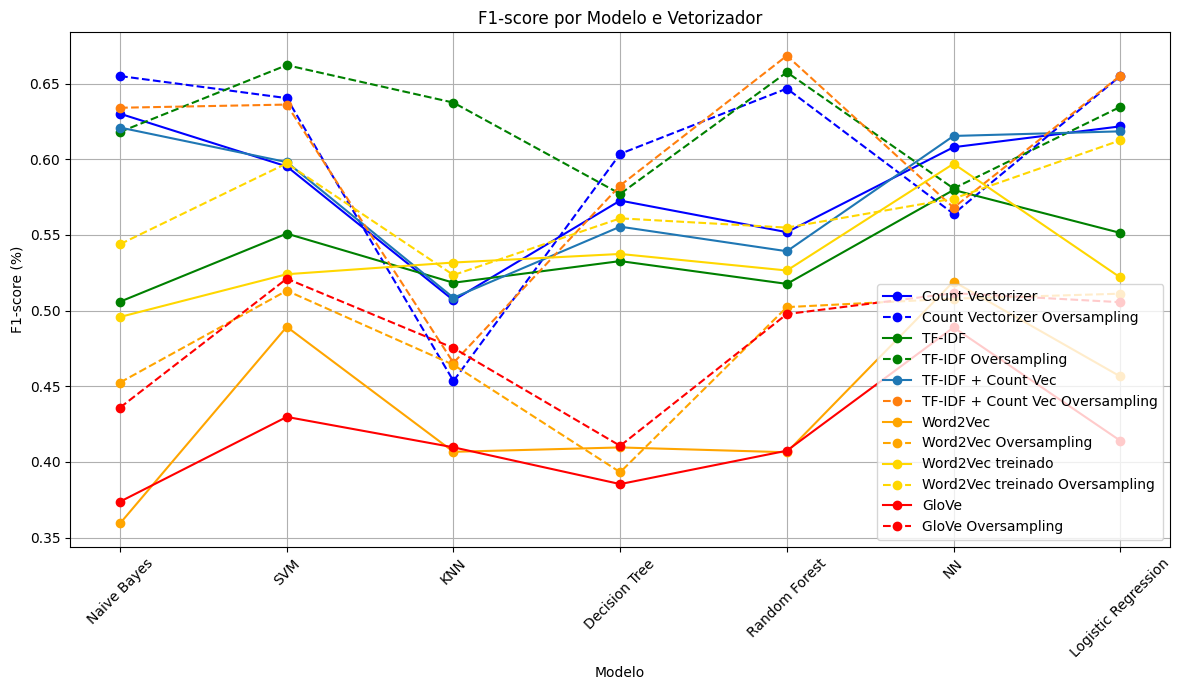

In [281]:
import matplotlib.pyplot as plt
import numpy as np

modelos = ["Naive Bayes", "SVM", "KNN", "Decision Tree", "Random Forest", "NN", "Logistic Regression"]

cores = {
    "Count Vectorizer": "blue",
    "TF-IDF": "green",
    "Word2Vec": "orange",
    "Word2Vec treinado": "gold",
    "GloVe": "red",
}

tipo_linha = {
    False: '-',   # sem oversampling (normal)
    True: '--'    # com oversampling
}

plt.figure(figsize=(12, 7))

for vetor_name, scores_dict in resultados.items():
    f1_scores = [scores_dict.get(modelo, np.nan) for modelo in modelos]
    
    # Determina se é oversampling analisando o nome do vetorizador
    oversample = 'Oversampling' in vetor_name
    
    # Nome base (retira "Oversampling")
    base = vetor_name.replace(' Oversampling', '')
    
    cor = cores.get(base, None)
    estilo = tipo_linha[oversample]
    
    plt.plot(modelos, f1_scores, marker='o', label=vetor_name, color=cor, linestyle=estilo)

plt.title("F1-score por Modelo e Vetorizador")
plt.xlabel("Modelo")
plt.ylabel("F1-score (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
